# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

import os
import sys
from pathlib import Path
import glob
from functools import  reduce

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"

sns.set(style="whitegrid")
#sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

# Load data and compute residuals

In [3]:
NUM_LAGS = 10
LAGS = [1, 6, 24]  # for HARX moving averages

dataset = (
    (
        pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
        .select(
            pl.col("datetime"),
            pl.col("vol"),
        )
        .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
        .sort("datetime")
    )
    .to_pandas()
    .set_index("datetime")
)

LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
true_volatility = dataset.loc[LAST_TRAINING_DATE:, "vol"]

In [4]:
true_volatility

datetime
2018-07-03 23:00:00    0.000285
2018-07-04 00:00:00    0.000241
2018-07-04 01:00:00    0.000240
2018-07-04 02:00:00    0.000173
2018-07-04 03:00:00    0.000177
                         ...   
2018-09-30 17:00:00    0.000025
2018-09-30 18:00:00    0.000014
2018-09-30 19:00:00    0.000024
2018-09-30 20:00:00    0.000089
2018-09-30 21:00:00    0.000034
Name: vol, Length: 1958, dtype: float64

## Benchmark predictions

In [5]:
# Find all CSV files with "expanding" in the filename
csv_files = glob.glob(str(PROJ_ROOT / "data" / "output" / "predictions" / "benchmarks" / "*expanding*.csv"))

dfs = []
for file in csv_files:
    df = pd.read_csv(file, parse_dates=["datetime"])
    # if there is `retraining_flag` column, drop it
    if "retraining_flag" in df.columns:
        df = df.drop(columns=["retraining_flag"])
    # drop unnamed columns
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    dfs.append(df)

# merge dfs
benchmarks_expanding = reduce(lambda left, right: pd.merge(left, right, on="datetime", how="outer"), dfs)
# set datetime as index
benchmarks_expanding = benchmarks_expanding.set_index("datetime")
benchmarks_expanding

ENET    ARIMAX      STRX      EWMA  Garch_normal  \
datetime                                                                    
2018-07-03 23:00:00  0.000157  0.000223  0.000185  0.000154      0.000043   
2018-07-04 00:00:00  0.000215  0.000180  0.000240  0.000163      0.000046   
2018-07-04 01:00:00  0.000216  0.000213  0.000249  0.000176      0.000056   
2018-07-04 02:00:00  0.000214  0.000211  0.000265  0.000203      0.000046   
2018-07-04 03:00:00  0.000187  0.000151  0.000206  0.000199      0.000043   
...                       ...       ...       ...       ...           ...   
2018-09-30 17:00:00  0.000065  0.000051  0.000035  0.000023      0.000062   
2018-09-30 18:00:00  0.000061  0.000032  0.000036  0.000024      0.000054   
2018-09-30 19:00:00  0.000049  0.000032  0.000025  0.000020      0.000053   
2018-09-30 20:00:00  0.000057  0.000048  0.000031  0.000023      0.000054   
2018-09-30 21:00:00  0.000102  0.000096  0.000065  0.000034      0.000055   

                          HAR     Naive        GP     ARIMA      HARX  \
datetime                                                                
2018-07-03 23:00:00  0.000166  0.000144  0.000192  0.000151  0.000149   
2018-07-04 00:00:00  0.000234  0.000285  0.000231  0.000213  0.000208   
2018-07-04 01:00:00  0.000218  0.000241  0.000234  0.000222  0.000196   
2018-07-04 02:00:00  0.000224  0.000240  0.000243  0.000224  0.000208   
2018-07-04 03:00:00  0.000190  0.000173  0.000187  0.000194  0.000169   
...                       ...       ...       ...       ...       ...   
2018-09-30 17:00:00  0.000050  0.000025  0.000036  0.000057  0.000046   
2018-09-30 18:00:00  0.000049  0.000025  0.000037  0.000057  0.000047   
2018-09-30 19:00:00  0.000036  0.000014  0.000026  0.000043  0.000034   
2018-09-30 20:00:00  0.000047  0.000024  0.000035  0.000050  0.000044   
2018-09-30 21:00:00  0.000084  0.000089  0.000068  0.000096  0.000078   

                          STR      XGBM        RF  
datetime                                           
2018-07-03 23:00:00  0.000188  0.000211  0.000151  
2018-07-04 00:00:00  0.000273  0.000168  0.000216  
2018-07-04 01:00:00  0.000260  0.000204  0.000203  
2018-07-04 02:00:00  0.000256  0.000257  0.000235  
2018-07-04 03:00:00  0.000224  0.000155  0.000170  
...                       ...       ...       ...  
2018-09-30 17:00:00  0.000037  0.000038  0.000066  
2018-09-30 18:00:00  0.000037  0.000054  0.000067  
2018-09-30 19:00:00  0.000027  0.000047  0.000045  
2018-09-30 20:00:00  0.000035  0.000057  0.000056  
2018-09-30 21:00:00  0.000065  0.000113  0.000112  

[1958 rows x 13 columns]

In [6]:
csv_files = glob.glob(str(PROJ_ROOT / "data" / "output" / "predictions" / "benchmarks" /  "*rolling*.csv"))
dfs = []
for file in csv_files:
    df = pd.read_csv(file, parse_dates=["datetime"])
    # if there is `retraining_flag` column, drop it
    if "retraining_flag" in df.columns:
        df = df.drop(columns=["retraining_flag"])
    # drop unnamed columns
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
    dfs.append(df)

# merge dfs
benchmarks_rolling = reduce(lambda left, right: pd.merge(left, right, on="datetime", how="outer"), dfs)
# set datetime as index
benchmarks_rolling = benchmarks_rolling.set_index("datetime")
benchmarks_rolling

XGBM      STRX        RF      EWMA       STR  \
datetime                                                                
2018-07-03 23:00:00  0.000211  0.000185  0.000182  0.000154  0.000188   
2018-07-04 00:00:00  0.000168  0.000240  0.000252  0.000163  0.000273   
2018-07-04 01:00:00  0.000204  0.000249  0.000241  0.000176  0.000260   
2018-07-04 02:00:00  0.000257  0.000265  0.000281  0.000203  0.000256   
2018-07-04 03:00:00  0.000155  0.000206  0.000185  0.000199  0.000224   
...                       ...       ...       ...       ...       ...   
2018-09-30 17:00:00  0.000082  0.000033  0.000056  0.000023  0.000038   
2018-09-30 18:00:00  0.000065  0.000036  0.000060  0.000024  0.000038   
2018-09-30 19:00:00  0.000061  0.000025  0.000040  0.000020  0.000028   
2018-09-30 20:00:00  0.000035  0.000031  0.000043  0.000023  0.000035   
2018-09-30 21:00:00  0.000109  0.000067  0.000087  0.000034  0.000068   

                          HAR        GP     ARIMA     Naive      HARX  \
datetime                                                                
2018-07-03 23:00:00  0.000193  0.000192  0.000176  0.000144  0.000173   
2018-07-04 00:00:00  0.000269  0.000231  0.000246  0.000285  0.000239   
2018-07-04 01:00:00  0.000249  0.000234  0.000253  0.000241  0.000224   
2018-07-04 02:00:00  0.000256  0.000243  0.000256  0.000240  0.000237   
2018-07-04 03:00:00  0.000214  0.000187  0.000218  0.000173  0.000191   
...                       ...       ...       ...       ...       ...   
2018-09-30 17:00:00  0.000047  0.000036  0.000051  0.000025  0.000043   
2018-09-30 18:00:00  0.000047  0.000039  0.000051  0.000025  0.000045   
2018-09-30 19:00:00  0.000035  0.000027  0.000039  0.000014  0.000032   
2018-09-30 20:00:00  0.000045  0.000036  0.000045  0.000024  0.000041   
2018-09-30 21:00:00  0.000082  0.000071  0.000082  0.000089  0.000075   

                         ENET  Garch_normal    ARIMAX  
datetime                                               
2018-07-03 23:00:00  0.000183      0.000043  0.000259  
2018-07-04 00:00:00  0.000247      0.000046  0.000207  
2018-07-04 01:00:00  0.000247      0.000056  0.000243  
2018-07-04 02:00:00  0.000244      0.000046  0.000241  
2018-07-04 03:00:00  0.000211      0.000043  0.000171  
...                       ...           ...       ...  
2018-09-30 17:00:00  0.000054      0.000027  0.000054  
2018-09-30 18:00:00  0.000056      0.000023  0.000036  
2018-09-30 19:00:00  0.000043      0.000021  0.000034  
2018-09-30 20:00:00  0.000052      0.000022  0.000049  
2018-09-30 21:00:00  0.000083      0.000024  0.000097  

[1958 rows x 13 columns]

## Temporal mixtures

In [7]:
# Find all CSV files with "expanding" in the filename
csv_files = glob.glob(str(PROJ_ROOT / "data" / "output" / "predictions" / "temporal_mixtures" /  "*expanding*.csv"))

dfs = []
for file in csv_files:
    df = pd.read_csv(file, parse_dates=["date"])
    # drop residual column
    df.drop(columns=["residual"], inplace=True)
    # rename the prediction column to the string in the filename before `_online_`
    df.rename(columns={df.columns[1]: Path(file).stem.split("_online_")[0]}, inplace=True)
    dfs.append(df)

# merge dfs
temporal_mixtures_expanding = reduce(lambda left, right: pd.merge(left, right, on="date", how="outer"), dfs)
# set date as index
temporal_mixtures_expanding = temporal_mixtures_expanding.set_index("date")
# rename the index to datetime
temporal_mixtures_expanding.index.name = "datetime"
temporal_mixtures_expanding

hinge_weibull  lognormal     hinge    normal  \
datetime                                                            
2018-07-04 00:00:00       0.000259   0.000327  0.000294  0.000317   
2018-07-04 01:00:00       0.000151   0.000245  0.000244  0.000205   
2018-07-04 02:00:00       0.000387   0.000264  0.000154  0.000137   
2018-07-04 03:00:00       0.000209   0.000246  0.000224  0.000157   
2018-07-04 04:00:00       0.000280   0.000243  0.000012  0.000020   
...                            ...        ...       ...       ...   
2018-09-30 17:00:00       0.000005   0.000070  0.000070  0.000056   
2018-09-30 18:00:00       0.000163   0.000067  0.000091  0.000065   
2018-09-30 19:00:00       0.000026   0.000066  0.000073  0.000048   
2018-09-30 20:00:00       0.000099   0.000076  0.000072  0.000055   
2018-09-30 21:00:00       0.000036   0.000089  0.000076  0.000073   

                     inverse_gaussian   weibull  hinge_inverse_gaussian  
datetime                                                                 
2018-07-04 00:00:00          0.000271  0.000348                0.000128  
2018-07-04 01:00:00          0.000301  0.000221                0.000274  
2018-07-04 02:00:00          0.000131  0.000275                0.000349  
2018-07-04 03:00:00          0.000116  0.000238                0.000386  
2018-07-04 04:00:00          0.000116  0.000132                0.000395  
...                               ...       ...                     ...  
2018-09-30 17:00:00          0.000078  0.000031                0.000032  
2018-09-30 18:00:00          0.000077  0.000207                0.000260  
2018-09-30 19:00:00          0.000077  0.000058                0.000044  
2018-09-30 20:00:00          0.000077  0.000114                0.000058  
2018-09-30 21:00:00          0.000077  0.000071                0.000060  

[1957 rows x 7 columns]

In [8]:
# Find all CSV files with "expanding" in the filename
csv_files = glob.glob(str(PROJ_ROOT / "data" / "output" / "predictions" / "temporal_mixtures" /  "*online*.csv"))
# drop csv files condaining "expanding" in the filename
csv_files = [file for file in csv_files if "expanding" not in file]

dfs = []
for file in csv_files:
    df = pd.read_csv(file, parse_dates=["date"])
    # drop residual column
    df.drop(columns=["residual"], inplace=True)
    # rename the prediction column to the string in the filename before `_online_`
    df.rename(columns={df.columns[1]: Path(file).stem.split("_online_")[0]}, inplace=True)
    dfs.append(df)

# merge dfs
temporal_mixtures_rolling = reduce(lambda left, right: pd.merge(left, right, on="date", how="outer"), dfs)
# set date as index
temporal_mixtures_rolling = temporal_mixtures_rolling.set_index("date")
temporal_mixtures_rolling.index.name = "datetime"
temporal_mixtures_rolling

hinge_weibull    normal  lognormal   weibull  \
datetime                                                            
2018-07-03 23:00:00       0.000157  0.000264   0.000551  0.000183   
2018-07-04 00:00:00       0.000236  0.000304   0.000369  0.000345   
2018-07-04 01:00:00       0.000129  0.000221   0.000216  0.000279   
2018-07-04 02:00:00       0.000427  0.000181   0.000157  0.000287   
2018-07-04 03:00:00       0.000287  0.000180   0.000220  0.000238   
...                            ...       ...        ...       ...   
2018-09-30 17:00:00       0.000016  0.000065   0.000060  0.000013   
2018-09-30 18:00:00       0.000043  0.000035   0.000073  0.000038   
2018-09-30 19:00:00       0.000042  0.000044   0.000061  0.000052   
2018-09-30 20:00:00       0.000048  0.000046   0.000037  0.000073   
2018-09-30 21:00:00       0.000063  0.000042   0.000064  0.000036   

                     inverse_gaussian     hinge  hinge_inverse_gaussian  
datetime                                                                 
2018-07-03 23:00:00          0.000172  0.000233                0.000188  
2018-07-04 00:00:00          0.000160  0.000278                0.000131  
2018-07-04 01:00:00          0.000210  0.000240                0.000184  
2018-07-04 02:00:00          0.000150  0.000197                0.000245  
2018-07-04 03:00:00          0.000197  0.000191                0.000312  
...                               ...       ...                     ...  
2018-09-30 17:00:00          0.000094  0.000055                0.000012  
2018-09-30 18:00:00          0.000066  0.000038                0.000050  
2018-09-30 19:00:00          0.000051  0.000037                0.000043  
2018-09-30 20:00:00          0.000056  0.000032                0.000043  
2018-09-30 21:00:00          0.000095  0.000048                0.000055  

[1958 rows x 7 columns]

## Neural Networks

In [18]:
# load nn predictions
neural_networks_rolling = pd.read_csv(PROJ_ROOT / "data" / "output" / "predictions" /  "neural_networks" / "output_retrain.csv", parse_dates=["datetime"])
neural_networks_rolling.set_index("datetime", inplace=True)

In [19]:
neural_networks_expanding = pd.read_csv(PROJ_ROOT / "data" / "output" / "predictions" /  "neural_networks" / "output_full.csv", parse_dates=["datetime"])
neural_networks_expanding.set_index("datetime", inplace=True)

In [20]:
neural_networks_unctrefit = pd.read_csv(PROJ_ROOT / "data" / "output" / "predictions" /  "neural_networks" / "output_bayesian.csv", parse_dates=["datetime"])
neural_networks_unctrefit.set_index("datetime", inplace=True)

## Merge results

In [21]:
predictions_rolling = pd.merge(benchmarks_rolling, neural_networks_rolling, left_index=True, right_on="datetime", how="outer")
predictions_rolling = pd.merge(predictions_rolling, temporal_mixtures_rolling, left_index=True, right_on="datetime", how="outer")
predictions_rolling

XGBM      STRX        RF      EWMA       STR  \
datetime                                                                
2018-07-03 23:00:00  0.000211  0.000185  0.000182  0.000154  0.000188   
2018-07-04 00:00:00  0.000168  0.000240  0.000252  0.000163  0.000273   
2018-07-04 01:00:00  0.000204  0.000249  0.000241  0.000176  0.000260   
2018-07-04 02:00:00  0.000257  0.000265  0.000281  0.000203  0.000256   
2018-07-04 03:00:00  0.000155  0.000206  0.000185  0.000199  0.000224   
...                       ...       ...       ...       ...       ...   
2018-09-30 17:00:00  0.000082  0.000033  0.000056  0.000023  0.000038   
2018-09-30 18:00:00  0.000065  0.000036  0.000060  0.000024  0.000038   
2018-09-30 19:00:00  0.000061  0.000025  0.000040  0.000020  0.000028   
2018-09-30 20:00:00  0.000035  0.000031  0.000043  0.000023  0.000035   
2018-09-30 21:00:00  0.000109  0.000067  0.000087  0.000034  0.000068   

                          HAR        GP     ARIMA     Naive      HARX  ...  \
datetime                                                               ...   
2018-07-03 23:00:00  0.000193  0.000192  0.000176  0.000144  0.000173  ...   
2018-07-04 00:00:00  0.000269  0.000231  0.000246  0.000285  0.000239  ...   
2018-07-04 01:00:00  0.000249  0.000234  0.000253  0.000241  0.000224  ...   
2018-07-04 02:00:00  0.000256  0.000243  0.000256  0.000240  0.000237  ...   
2018-07-04 03:00:00  0.000214  0.000187  0.000218  0.000173  0.000191  ...   
...                       ...       ...       ...       ...       ...  ...   
2018-09-30 17:00:00  0.000047  0.000036  0.000051  0.000025  0.000043  ...   
2018-09-30 18:00:00  0.000047  0.000039  0.000051  0.000025  0.000045  ...   
2018-09-30 19:00:00  0.000035  0.000027  0.000039  0.000014  0.000032  ...   
2018-09-30 20:00:00  0.000045  0.000036  0.000045  0.000024  0.000041  ...   
2018-09-30 21:00:00  0.000082  0.000071  0.000082  0.000089  0.000075  ...   

                     TransformerPredictor  SigmaLSTMPredictor  \
datetime                                                        
2018-07-03 23:00:00              0.000058            0.017133   
2018-07-04 00:00:00              0.000059            0.010147   
2018-07-04 01:00:00              0.000059            0.004732   
2018-07-04 02:00:00              0.000059            0.005149   
2018-07-04 03:00:00              0.000059            0.000219   
...                                   ...                 ...   
2018-09-30 17:00:00              0.000055            0.001666   
2018-09-30 18:00:00              0.000055            0.004766   
2018-09-30 19:00:00              0.000055            0.007705   
2018-09-30 20:00:00              0.000055            0.052393   
2018-09-30 21:00:00                   NaN                 NaN   

                     ViEvalPredictor  hinge_weibull    normal  lognormal  \
datetime                                                                   
2018-07-03 23:00:00         0.000066       0.000157  0.000264   0.000551   
2018-07-04 00:00:00         0.000065       0.000236  0.000304   0.000369   
2018-07-04 01:00:00         0.000067       0.000129  0.000221   0.000216   
2018-07-04 02:00:00         0.000066       0.000427  0.000181   0.000157   
2018-07-04 03:00:00         0.000066       0.000287  0.000180   0.000220   
...                              ...            ...       ...        ...   
2018-09-30 17:00:00         0.000065       0.000016  0.000065   0.000060   
2018-09-30 18:00:00         0.000066       0.000043  0.000035   0.000073   
2018-09-30 19:00:00         0.000066       0.000042  0.000044   0.000061   
2018-09-30 20:00:00         0.000066       0.000048  0.000046   0.000037   
2018-09-30 21:00:00              NaN       0.000063  0.000042   0.000064   

                      weibull  inverse_gaussian     hinge  \
datetime                                                    
2018-07-03 23:00:00  0.000183          0.000172  0.000233   
2018-07-04 00:00:00  0.000345          0.0

In [22]:
residuals_rolling = predictions_rolling.copy()
for col in predictions_rolling.columns:
    residuals_rolling[col] = true_volatility - predictions_rolling[col]
residuals_rolling

XGBM          STRX            RF          EWMA  \
datetime                                                                  
2018-07-03 23:00:00  0.000074  1.005416e-04  1.029840e-04  1.313441e-04   
2018-07-04 00:00:00  0.000073  7.323912e-07 -1.147780e-05  7.744345e-05   
2018-07-04 01:00:00  0.000036 -8.689438e-06 -7.099528e-07  6.370525e-05   
2018-07-04 02:00:00 -0.000084 -9.229524e-05 -1.084535e-04 -3.038477e-05   
2018-07-04 03:00:00  0.000022 -2.953656e-05 -7.962047e-06 -2.188242e-05   
...                       ...           ...           ...           ...   
2018-09-30 17:00:00 -0.000057 -7.311844e-06 -3.098286e-05  1.975271e-06   
2018-09-30 18:00:00 -0.000051 -2.270210e-05 -4.601036e-05 -1.004763e-05   
2018-09-30 19:00:00 -0.000038 -1.201047e-06 -1.562239e-05  3.687061e-06   
2018-09-30 20:00:00  0.000054  5.834051e-05  4.609973e-05  6.634956e-05   
2018-09-30 21:00:00 -0.000075 -3.247685e-05 -5.330417e-05  4.167242e-07   

                          STR       HAR        GP     ARIMA         Naive  \
datetime                                                                    
2018-07-03 23:00:00  0.000097  0.000093  0.000094  0.000109  1.415531e-04   
2018-07-04 00:00:00 -0.000032 -0.000029  0.000010 -0.000005 -4.482038e-05   
2018-07-04 01:00:00 -0.000020 -0.000009  0.000006 -0.000013 -6.905532e-07   
2018-07-04 02:00:00 -0.000083 -0.000084 -0.000071 -0.000083 -6.731889e-05   
2018-07-04 03:00:00 -0.000047 -0.000037 -0.000010 -0.000041  4.404069e-06   
...                       ...       ...       ...       ...           ...   
2018-09-30 17:00:00 -0.000013 -0.000022 -0.000011 -0.000025  1.104546e-08   
2018-09-30 18:00:00 -0.000025 -0.000034 -0.000025 -0.000037 -1.169684e-05   
2018-09-30 19:00:00 -0.000004 -0.000011 -0.000003 -0.000015  1.022298e-05   
2018-09-30 20:00:00  0.000054  0.000044  0.000053  0.000044  6.531835e-05   
2018-09-30 21:00:00 -0.000034 -0.000047 -0.000037 -0.000048 -5.509286e-05   

                         HARX  ...  TransformerPredictor  SigmaLSTMPredictor  \
datetime                       ...                                             
2018-07-03 23:00:00  0.000112  ...              0.000228           -0.016848   
2018-07-04 00:00:00  0.000001  ...              0.000182           -0.009906   
2018-07-04 01:00:00  0.000016  ...              0.000181           -0.004492   
2018-07-04 02:00:00 -0.000065  ...              0.000113           -0.004976   
2018-07-04 03:00:00 -0.000014  ...              0.000118           -0.000043   
...                       ...  ...                   ...                 ...   
2018-09-30 17:00:00 -0.000017  ...             -0.000029           -0.001640   
2018-09-30 18:00:00 -0.000032  ...             -0.000041           -0.004752   
2018-09-30 19:00:00 -0.000008  ...             -0.000031           -0.007681   
2018-09-30 20:00:00  0.000048  ...              0.000034           -0.052304   
2018-09-30 21:00:00 -0.000041  ...                   NaN                 NaN   

                     ViEvalPredictor  hinge_weibull    normal  lognormal  \
datetime                                                                   
2018-07-03 23:00:00         0.000219       0.000128  0.000021  -0.000266   
2018-07-04 00:00:00         0.000175       0.000005 -0.000063  -0.000128   
2018-07-04 01:00:00         0.000172       0.000110  0.000019   0.000024   
2018-07-04 02:00:00         0.000107      -0.000255 -0.000009   0.000016   
2018-07-04 03:00:00         0.000111      -0.000111 -0.000003  -0.000043   
...                              ...            ...       ...        ...   
2018-09-30 17:00:00        -0.000040       0.000009 -0.000040  -0.000035   
2018-09-30 18:00:00        -0.000052      -0.000030 -0.000022  -0.000059   
2018-09-30 19:00:00        -0.000042      -0.000018 -0.000020  -0.000037   
2018-09-30 20:00:00         0.000023       0.000041  0.000043   0.000052   
2018-09-30 21:00:00              NaN      -0.000029 -0.000008  -0.000030   

                 

In [23]:
predictions_expanding = pd.merge(benchmarks_expanding, neural_networks_expanding, left_index=True, right_on="datetime", how="outer")
predictions_expanding = pd.merge(predictions_expanding, temporal_mixtures_expanding, left_index=True, right_on="datetime", how="outer")
predictions_expanding = pd.merge(predictions_expanding, neural_networks_unctrefit, left_index=True, right_on="datetime", how="outer")
predictions_expanding.set_index("datetime", inplace=True)
predictions_expanding

ENET    ARIMAX      STRX      EWMA  Garch_normal  \
datetime                                                                    
2018-07-03 23:00:00  0.000157  0.000223  0.000185  0.000154      0.000043   
2018-07-03 23:00:00       NaN       NaN       NaN       NaN           NaN   
2018-07-04 00:00:00  0.000215  0.000180  0.000240  0.000163      0.000046   
2018-07-04 01:00:00  0.000216  0.000213  0.000249  0.000176      0.000056   
2018-07-04 02:00:00  0.000214  0.000211  0.000265  0.000203      0.000046   
...                       ...       ...       ...       ...           ...   
2018-09-30 17:00:00  0.000065  0.000051  0.000035  0.000023      0.000062   
2018-09-30 18:00:00  0.000061  0.000032  0.000036  0.000024      0.000054   
2018-09-30 19:00:00  0.000049  0.000032  0.000025  0.000020      0.000053   
2018-09-30 20:00:00  0.000057  0.000048  0.000031  0.000023      0.000054   
2018-09-30 21:00:00  0.000102  0.000096  0.000065  0.000034      0.000055   

                          HAR     Naive        GP     ARIMA      HARX  ...  \
datetime                                                               ...   
2018-07-03 23:00:00  0.000166  0.000144  0.000192  0.000151  0.000149  ...   
2018-07-03 23:00:00       NaN       NaN       NaN       NaN       NaN  ...   
2018-07-04 00:00:00  0.000234  0.000285  0.000231  0.000213  0.000208  ...   
2018-07-04 01:00:00  0.000218  0.000241  0.000234  0.000222  0.000196  ...   
2018-07-04 02:00:00  0.000224  0.000240  0.000243  0.000224  0.000208  ...   
...                       ...       ...       ...       ...       ...  ...   
2018-09-30 17:00:00  0.000050  0.000025  0.000036  0.000057  0.000046  ...   
2018-09-30 18:00:00  0.000049  0.000025  0.000037  0.000057  0.000047  ...   
2018-09-30 19:00:00  0.000036  0.000014  0.000026  0.000043  0.000034  ...   
2018-09-30 20:00:00  0.000047  0.000024  0.000035  0.000050  0.000044  ...   
2018-09-30 21:00:00  0.000084  0.000089  0.000068  0.000096  0.000078  ...   

                     SigmaLSTMPredictor  ViEvalPredictor  hinge_weibull  \
datetime                                                                  
2018-07-03 23:00:00        3.233786e-03         0.000057            NaN   
2018-07-03 23:00:00                 NaN              NaN            NaN   
2018-07-04 00:00:00        4.006117e-03         0.000054       0.000259   
2018-07-04 01:00:00        1.238076e-02         0.000065       0.000151   
2018-07-04 02:00:00        1.444009e-05         0.000057       0.000387   
...                                 ...              ...            ...   
2018-09-30 17:00:00        1.961033e-02         0.000055       0.000005   
2018-09-30 18:00:00        5.776174e-07         0.000058       0.000163   
2018-09-30 19:00:00        1.687220e-03         0.000057       0.000026   
2018-09-30 20:00:00        1.801251e-02         0.000059       0.000099   
2018-09-30 21:00:00                 NaN              NaN       0.000036   

                     lognormal     hinge    normal  inverse_gaussian  \
datetime                                                               
2018-07-03 23:00:00        NaN       NaN       NaN               NaN   
2018-07-03 23:00:00        NaN       NaN       NaN               NaN   
2018-07-04 00:00:00   0.000327  0.000294  0.000317          0.000271   
2018-07-04 01:00:00   0.000245  0.000244  0.000205          0.000301   
2018-07-04 02:00:00   0.000264  0.000154  0.000137          0.000131   
...                        ...       ...       ...               ...   
2018-09-30 17:00:00   0.000070  0.000070  0.000056          0.000078   
2018-09-30 18:00:00   0.000067  0.000091  0.000065          0.000077   
2018-09-30 19:00:00   0.000066  0.000073  0.000048          0.000077   
2018-09-30 20:00:00   0.000076  0.000072  0.000055          0.000077   
2018-09-30 21:00:00   0.000089  0.000076  0.000073          0.000077   

                      weibull  hinge_inverse_gaussian  \
datetime                              

In [24]:
residuals_expanding = predictions_expanding.copy()
for col in predictions_expanding.columns:
    residuals_expanding[col] = true_volatility - predictions_expanding[col]
residuals_expanding#.dropna(inplace=True)
residuals_expanding

ENET    ARIMAX          STRX          EWMA  \
datetime                                                              
2018-07-03 23:00:00  0.000128  0.000063  1.005416e-04  1.313441e-04   
2018-07-03 23:00:00       NaN       NaN           NaN           NaN   
2018-07-04 00:00:00  0.000026  0.000061  7.323912e-07  7.744345e-05   
2018-07-04 01:00:00  0.000024  0.000027 -8.689438e-06  6.370525e-05   
2018-07-04 02:00:00 -0.000041 -0.000038 -9.229524e-05 -3.038477e-05   
...                       ...       ...           ...           ...   
2018-09-30 17:00:00 -0.000040 -0.000025 -9.253757e-06  1.975271e-06   
2018-09-30 18:00:00 -0.000048 -0.000018 -2.197086e-05 -1.004763e-05   
2018-09-30 19:00:00 -0.000025 -0.000008 -1.120187e-06  3.687061e-06   
2018-09-30 20:00:00  0.000032  0.000041  5.782103e-05  6.634956e-05   
2018-09-30 21:00:00 -0.000068 -0.000061 -3.097499e-05  4.167242e-07   

                     Garch_normal       HAR         Naive        GP     ARIMA  \
datetime                                                                        
2018-07-03 23:00:00      0.000243  0.000120  1.415531e-04  0.000094  0.000134   
2018-07-03 23:00:00           NaN       NaN           NaN       NaN       NaN   
2018-07-04 00:00:00      0.000194  0.000006 -4.482038e-05  0.000010  0.000027   
2018-07-04 01:00:00      0.000184  0.000022 -6.905532e-07  0.000006  0.000018   
2018-07-04 02:00:00      0.000127 -0.000052 -6.731889e-05 -0.000071 -0.000051   
...                           ...       ...           ...       ...       ...   
2018-09-30 17:00:00     -0.000037 -0.000025  1.104546e-08 -0.000011 -0.000031   
2018-09-30 18:00:00     -0.000041 -0.000036 -1.169684e-05 -0.000023 -0.000043   
2018-09-30 19:00:00     -0.000029 -0.000013  1.022298e-05 -0.000002 -0.000019   
2018-09-30 20:00:00      0.000036  0.000042  6.531835e-05  0.000054  0.000039   
2018-09-30 21:00:00     -0.000021 -0.000050 -5.509286e-05 -0.000034 -0.000061   

                         HARX  ...  SigmaLSTMPredictor  ViEvalPredictor  \
datetime                       ...                                        
2018-07-03 23:00:00  0.000136  ...           -0.002948         0.000228   
2018-07-03 23:00:00       NaN  ...                 NaN              NaN   
2018-07-04 00:00:00  0.000033  ...           -0.003766         0.000187   
2018-07-04 01:00:00  0.000044  ...           -0.012141         0.000175   
2018-07-04 02:00:00 -0.000035  ...            0.000158         0.000115   
...                       ...  ...                 ...              ...   
2018-09-30 17:00:00 -0.000021  ...           -0.019585        -0.000029   
2018-09-30 18:00:00 -0.000033  ...            0.000013        -0.000044   
2018-09-30 19:00:00 -0.000010  ...           -0.001663        -0.000033   
2018-09-30 20:00:00  0.000045  ...           -0.017923         0.000030   
2018-09-30 21:00:00 -0.000044  ...                 NaN              NaN   

                     hinge_weibull  lognormal     hinge    normal  \
datetime                                                            
2018-07-03 23:00:00            NaN        NaN       NaN       NaN   
2018-07-03 23:00:00            NaN        NaN       NaN       NaN   
2018-07-04 00:00:00      -0.000018  -0.000087 -0.000054 -0.000076   
2018-07-04 01:00:00       0.000089  -0.000005 -0.000004  0.000035   
2018-07-04 02:00:00      -0.000215  -0.000091  0.000019  0.000036   
...                            ...        ...       ...       ...   
2018-09-30 17:00:00       0.000020  -0.000044 -0.000045 -0.000030   
2018-09-30 18:00:00      -0.000149  -0.000053 -0.000078 -0.000051   
2018-09-30 19:00:00      -0.000002  -0.000042 -0.000049 -0.000025   
2018-09-30 20:00:00      -0.000009   0.000014  0.000017  0.000034   
2018-09-30 21:00:00      -0.000002  -0.000055 -0.000042 -0.000039   

                     inverse_gaussian   weibull  hinge_inverse_gaussian  \
datetime                                                                  
2018-07-03 23:00:00    

In [25]:
# where are nans
residuals_expanding.isna().sum().sort_values(ascending=False)

LSTMSoftplusPredictorUnctRefit    2
LSTMSoftplusPredictor             2
hinge_inverse_gaussian            2
weibull                           2
inverse_gaussian                  2
normal                            2
hinge                             2
lognormal                         2
hinge_weibull                     2
ViEvalPredictor                   2
SigmaLSTMPredictor                2
TransformerPredictor              2
ENET                              1
ARIMAX                            1
XGBM                              1
STR                               1
HARX                              1
ARIMA                             1
GP                                1
Naive                             1
HAR                               1
Garch_normal                      1
EWMA                              1
STRX                              1
RF                                1
dtype: int64

In [26]:
residuals_expanding.dropna(inplace=True)
residuals_expanding

ENET    ARIMAX          STRX      EWMA  Garch_normal  \
datetime                                                                        
2018-07-04 00:00:00  0.000026  0.000061  7.323912e-07  0.000077      0.000194   
2018-07-04 01:00:00  0.000024  0.000027 -8.689438e-06  0.000064      0.000184   
2018-07-04 02:00:00 -0.000041 -0.000038 -9.229524e-05 -0.000030      0.000127   
2018-07-04 03:00:00 -0.000010  0.000026 -2.953656e-05 -0.000022      0.000134   
2018-07-04 04:00:00 -0.000002  0.000038 -2.657875e-05 -0.000029      0.000139   
...                       ...       ...           ...       ...           ...   
2018-09-30 16:00:00 -0.000038 -0.000033 -1.528179e-05 -0.000007     -0.000050   
2018-09-30 17:00:00 -0.000040 -0.000025 -9.253757e-06  0.000002     -0.000037   
2018-09-30 18:00:00 -0.000048 -0.000018 -2.197086e-05 -0.000010     -0.000041   
2018-09-30 19:00:00 -0.000025 -0.000008 -1.120187e-06  0.000004     -0.000029   
2018-09-30 20:00:00  0.000032  0.000041  5.782103e-05  0.000066      0.000036   

                          HAR         Naive        GP     ARIMA      HARX  \
datetime                                                                    
2018-07-04 00:00:00  0.000006 -4.482038e-05  0.000010  0.000027  0.000033   
2018-07-04 01:00:00  0.000022 -6.905532e-07  0.000006  0.000018  0.000044   
2018-07-04 02:00:00 -0.000052 -6.731889e-05 -0.000071 -0.000051 -0.000035   
2018-07-04 03:00:00 -0.000013  4.404069e-06 -0.000010 -0.000017  0.000008   
2018-07-04 04:00:00 -0.000012  4.806283e-06 -0.000010 -0.000004  0.000010   
...                       ...           ...       ...       ...       ...   
2018-09-30 16:00:00 -0.000032 -6.693634e-06 -0.000024 -0.000031 -0.000034   
2018-09-30 17:00:00 -0.000025  1.104546e-08 -0.000011 -0.000031 -0.000021   
2018-09-30 18:00:00 -0.000036 -1.169684e-05 -0.000023 -0.000043 -0.000033   
2018-09-30 19:00:00 -0.000013  1.022298e-05 -0.000002 -0.000019 -0.000010   
2018-09-30 20:00:00  0.000042  6.531835e-05  0.000054  0.000039  0.000045   

                     ...  SigmaLSTMPredictor  ViEvalPredictor  hinge_weibull  \
datetime             ...                                                       
2018-07-04 00:00:00  ...           -0.003766         0.000187      -0.000018   
2018-07-04 01:00:00  ...           -0.012141         0.000175       0.000089   
2018-07-04 02:00:00  ...            0.000158         0.000115      -0.000215   
2018-07-04 03:00:00  ...           -0.015836         0.000120      -0.000032   
2018-07-04 04:00:00  ...           -0.000077         0.000125      -0.000098   
...                  ...                 ...              ...            ...   
2018-09-30 16:00:00  ...           -0.007139        -0.000040      -0.000049   
2018-09-30 17:00:00  ...           -0.019585        -0.000029       0.000020   
2018-09-30 18:00:00  ...            0.000013        -0.000044      -0.000149   
2018-09-30 19:00:00  ...           -0.001663        -0.000033      -0.000002   
2018-09-30 20:00:00  ...           -0.017923         0.000030      -0.000009   

                     lognormal     hinge    normal  inverse_gaussian  \
datetime                                                               
2018-07-04 00:00:00  -0.000087 -0.000054 -0.000076         -0.000031   
2018-07-04 01:00:00  -0.000005 -0.000004  0.000035         -0.000061   
2018-07-04 02:00:00  -0.000091  0.000019  0.000036          0.000041   
2018-07-04 03:00:00  -0.000070 -0.000047  0.000020          0.000061   
2018-07-04 04:00:00  -0.000061  0.000170  0.000161          0.000066   
...                        ...       ...       ...               ...   
2018-09-30 16:00:00  -0.000044 -0.000047 -0.000025         -0.000052   
2018-09-30 17:00:00  -0.000044 -0.000045 -0.000030         -0.000052   
2018-09-30 18:00:00  -0.000053 -0.000078 -0.000051         -0.000064   
2018-09-30 19:00:00  -0.000042 -0.000049 -0.000025         -0.000053   
2018-09-30 20:00:00   0.000014  0.000017  0.000034          0.00

# Analysis of residuals (from expanding training set)

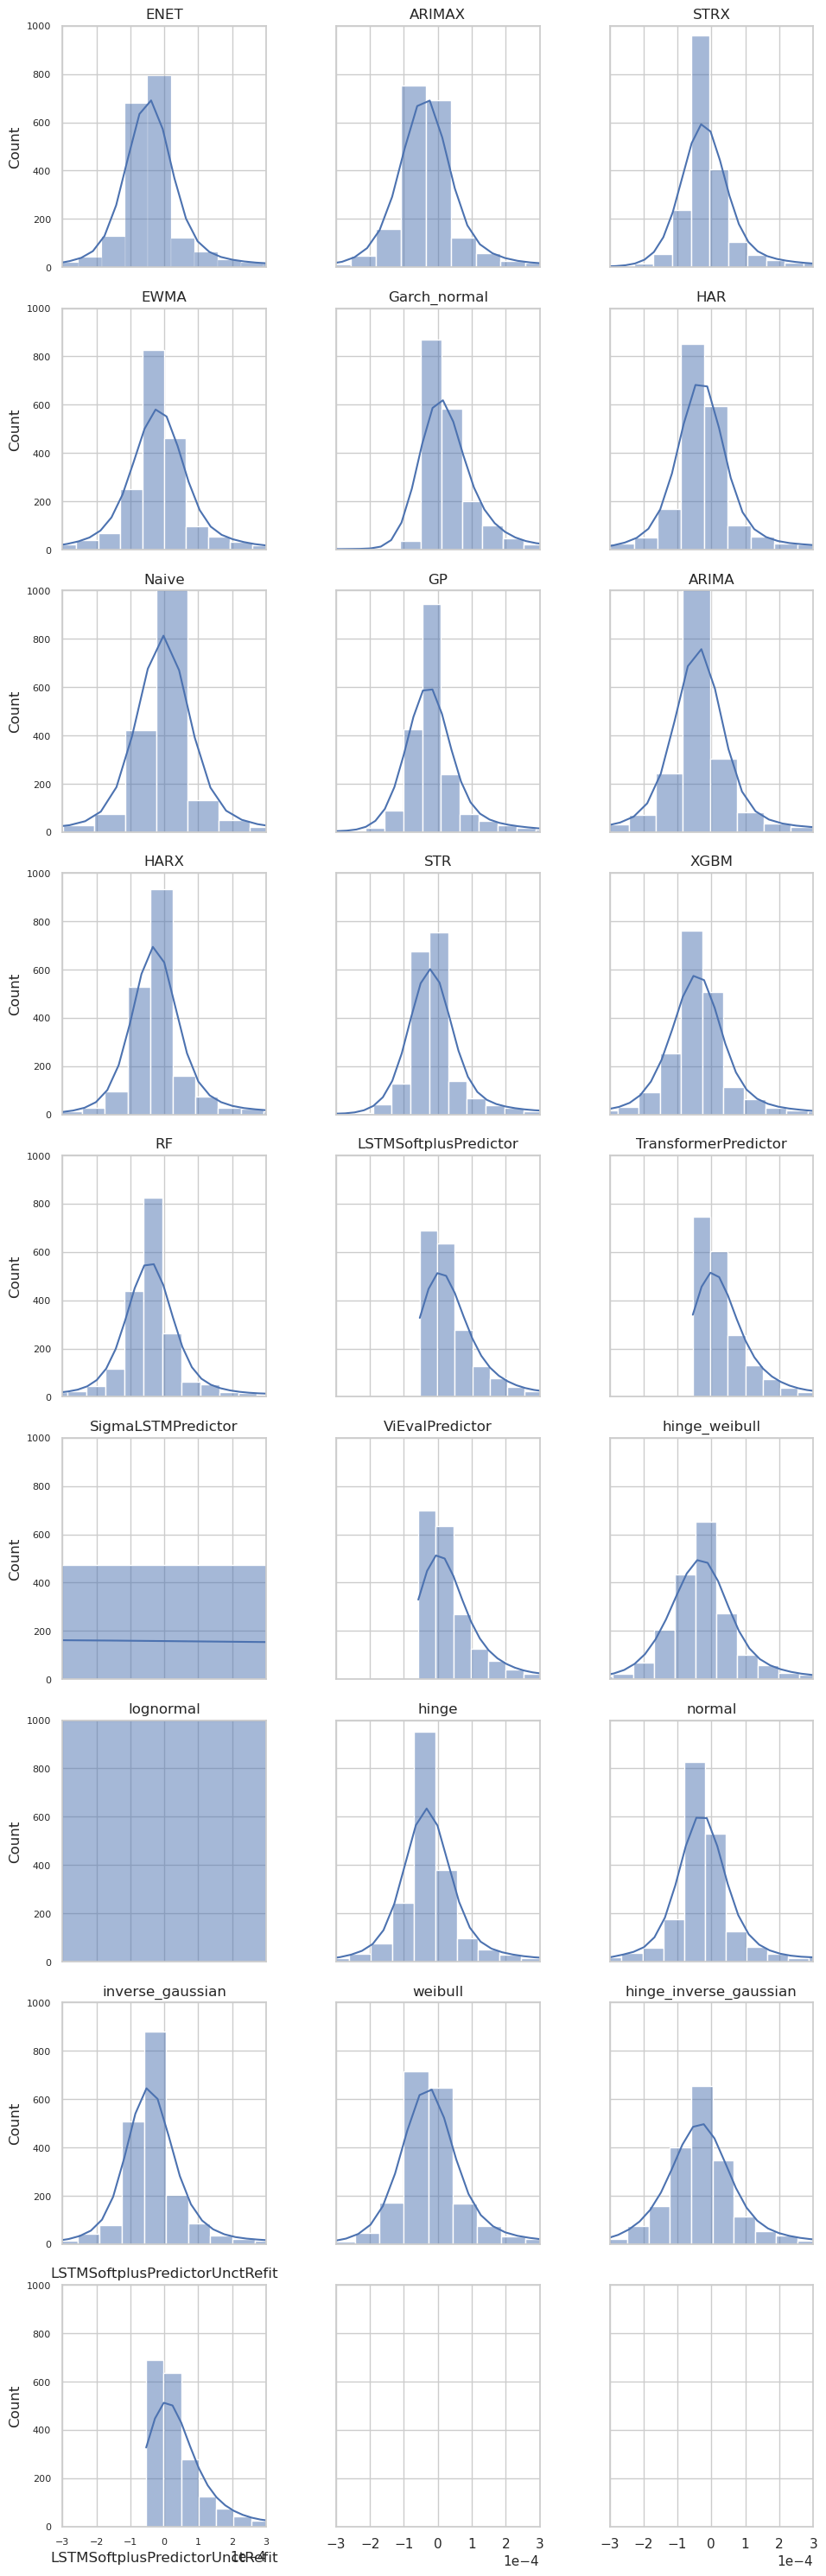

In [27]:
# plot distribution of residuals in 3 columns of subplots
# share x and y axis limits
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(10, 30), sharex=True, sharey=True)

for ax, col in zip(axes.flatten(), residuals_expanding.columns):
    ax.tick_params(labelsize=8)
    sns.histplot(residuals_expanding[col], bins=100, kde=True, ax=ax)
    ax.set_title(f"{col}")
    #ax.set_xlabel(None)
    #ax.set_ylabel(None)

    ax.set_xlim(-0.0003, 0.0003)
    ax.set_ylim(0, 1000)

plt.tight_layout()
for ax in axes.flatten():
    ax.ticklabel_format(style='sci', scilimits=(0,0), axis='x')
plt.show()


## Compute RMSE and MAE for all models

In [28]:
# compute RMSE, MAE for all models
rmse_rolling = {}
mae_rolling = {}
for col in predictions_rolling.columns:
    # round to 4 decimal places
    rmse_rolling[col] = np.round(np.sqrt(np.mean(residuals_rolling[col] ** 2)), 7)
    mae_rolling[col] = np.round(np.mean(np.abs(residuals_rolling[col])), 7)

results_rolling = pd.DataFrame({"RMSE": rmse_rolling, "MAE": mae_rolling})

In [29]:
results_rolling.sort_values(by="RMSE", ascending=True).head(25)

RMSE           MAE
HAR                     2.279000e-04  8.400000e-05
STR                     2.287000e-04  7.560000e-05
HARX                    2.296000e-04  8.100000e-05
ARIMA                   2.298000e-04  8.750000e-05
STRX                    2.307000e-04  7.630000e-05
ENET                    2.307000e-04  8.660000e-05
GP                      2.316000e-04  7.900000e-05
RF                      2.340000e-04  8.920000e-05
inverse_gaussian        2.358000e-04  9.090000e-05
ARIMAX                  2.365000e-04  9.210000e-05
normal                  2.369000e-04  8.480000e-05
hinge                   2.439000e-04  9.080000e-05
XGBM                    2.457000e-04  1.066000e-04
hinge_inverse_gaussian  2.459000e-04  9.680000e-05
ViEvalPredictor         2.466000e-04  8.050000e-05
hinge_weibull           2.469000e-04  9.340000e-05
TransformerPredictor    2.488000e-04  8.140000e-05
LSTMSoftplusPredictor   2.488000e-04  8.160000e-05
Garch_normal            2.494000e-04  9.420000e-05
EWMA                    2.551000e-04  9.380000e-05
Naive                   2.826000e-04  9.210000e-05
SigmaLSTMPredictor      2.098910e-02  1.242760e-02
weibull                 6.094860e+00  1.378381e-01
lognormal               2.519165e+15  5.693118e+13

In [30]:
results_rolling.sort_values(by="MAE", ascending=True).head(25)

RMSE           MAE
STR                     2.287000e-04  7.560000e-05
STRX                    2.307000e-04  7.630000e-05
GP                      2.316000e-04  7.900000e-05
ViEvalPredictor         2.466000e-04  8.050000e-05
HARX                    2.296000e-04  8.100000e-05
TransformerPredictor    2.488000e-04  8.140000e-05
LSTMSoftplusPredictor   2.488000e-04  8.160000e-05
HAR                     2.279000e-04  8.400000e-05
normal                  2.369000e-04  8.480000e-05
ENET                    2.307000e-04  8.660000e-05
ARIMA                   2.298000e-04  8.750000e-05
RF                      2.340000e-04  8.920000e-05
hinge                   2.439000e-04  9.080000e-05
inverse_gaussian        2.358000e-04  9.090000e-05
ARIMAX                  2.365000e-04  9.210000e-05
Naive                   2.826000e-04  9.210000e-05
hinge_weibull           2.469000e-04  9.340000e-05
EWMA                    2.551000e-04  9.380000e-05
Garch_normal            2.494000e-04  9.420000e-05
hinge_inverse_gaussian  2.459000e-04  9.680000e-05
XGBM                    2.457000e-04  1.066000e-04
SigmaLSTMPredictor      2.098910e-02  1.242760e-02
weibull                 6.094860e+00  1.378381e-01
lognormal               2.519165e+15  5.693118e+13

In [31]:
# compute RMSE, MAE for all models
rmse_expanding = {}
mae_expanding = {}
for col in predictions_expanding.columns:
    # round to 4 decimal places
    rmse_expanding[col] = np.round(np.sqrt(np.mean(residuals_expanding[col] ** 2)), 7)
    mae_expanding[col] = np.round(np.mean(np.abs(residuals_expanding[col])), 7)

results_expanding = pd.DataFrame({"RMSE": rmse_expanding, "MAE": mae_expanding})

In [32]:
results_expanding.sort_values(by="RMSE", ascending=True).head(25)

RMSE         MAE
STR                                0.000228    0.000075
GP                                 0.000229    0.000077
STRX                               0.000229    0.000076
HARX                               0.000230    0.000082
HAR                                0.000230    0.000086
XGBM                               0.000232    0.000098
RF                                 0.000232    0.000093
ENET                               0.000232    0.000093
hinge                              0.000232    0.000086
normal                             0.000233    0.000086
Garch_normal                       0.000237    0.000080
inverse_gaussian                   0.000239    0.000095
ARIMAX                             0.000240    0.000093
weibull                            0.000244    0.000093
ARIMA                              0.000244    0.000096
hinge_weibull                      0.000245    0.000102
hinge_inverse_gaussian             0.000246    0.000103
ViEvalPredictor                    0.000248    0.000081
LSTMSoftplusPredictor              0.000249    0.000082
LSTMSoftplusPredictorUnctRefit     0.000249    0.000082
TransformerPredictor               0.000249    0.000082
EWMA                               0.000255    0.000094
Naive                              0.000283    0.000092
SigmaLSTMPredictor                 0.029052    0.016281
lognormal                       5805.182994  131.275132

In [33]:
results_expanding.sort_values(by="MAE", ascending=True).head(25)

RMSE         MAE
STR                                0.000228    0.000075
STRX                               0.000229    0.000076
GP                                 0.000229    0.000077
Garch_normal                       0.000237    0.000080
ViEvalPredictor                    0.000248    0.000081
TransformerPredictor               0.000249    0.000082
HARX                               0.000230    0.000082
LSTMSoftplusPredictorUnctRefit     0.000249    0.000082
LSTMSoftplusPredictor              0.000249    0.000082
normal                             0.000233    0.000086
HAR                                0.000230    0.000086
hinge                              0.000232    0.000086
Naive                              0.000283    0.000092
ENET                               0.000232    0.000093
ARIMAX                             0.000240    0.000093
RF                                 0.000232    0.000093
weibull                            0.000244    0.000093
EWMA                               0.000255    0.000094
inverse_gaussian                   0.000239    0.000095
ARIMA                              0.000244    0.000096
XGBM                               0.000232    0.000098
hinge_weibull                      0.000245    0.000102
hinge_inverse_gaussian             0.000246    0.000103
SigmaLSTMPredictor                 0.029052    0.016281
lognormal                       5805.182994  131.275132

## Model Confidence Sets

In [34]:
from model_confidence_set import ModelConfidenceSet

In [35]:
l1_loss = residuals_expanding.abs()
l2_loss = residuals_expanding.pow(2)

In [36]:
mcs_l2 = ModelConfidenceSet(l2_loss, n_boot=5000, alpha=0.05, show_progress=True)

# Compute the MCS
mcs_l2.compute()

# Retrieve the results as a pandas DataFrame (use as_dataframe=False for a dict)
results_l2 = mcs_l2.results(as_dataframe=True)
results_l2.sort_values(by="pvalues", ascending=False, inplace=True)
results_l2.head(25)

Computing MCS: 100%|██████████| 24/24 [00:00<00:00, 46.64model/s]


pvalues    status
models                                           
STR                              1.0000  included
GP                               0.4210  included
HARX                             0.4210  included
STRX                             0.3136  included
XGBM                             0.3136  included
HAR                              0.3136  included
RF                               0.3136  included
hinge                            0.1068  included
normal                           0.0458  excluded
ARIMAX                           0.0022  excluded
ENET                             0.0022  excluded
weibull                          0.0022  excluded
Garch_normal                     0.0022  excluded
ARIMA                            0.0022  excluded
inverse_gaussian                 0.0022  excluded
EWMA                             0.0022  excluded
ViEvalPredictor                  0.0022  excluded
TransformerPredictor             0.0022  excluded
LSTMSoftplusPredictor            0.0012  excluded
hinge_weibull                    0.0012  excluded
LSTMSoftplusPredictorUnctRefit   0.0012  excluded
hinge_inverse_gaussian           0.0002  excluded
Naive                            0.0002  excluded
SigmaLSTMPredictor               0.0000  excluded
lognormal                        0.0000  excluded

In [37]:
mcs_l1 = ModelConfidenceSet(l1_loss, n_boot=5000, alpha=0.05, show_progress=True)

# Compute the MCS
mcs_l1.compute()

# Retrieve the results as a pandas DataFrame (use as_dataframe=False for a dict)
results_l1 = mcs_l1.results(as_dataframe=True)
results_l1.sort_values(by="pvalues", ascending=False, inplace=True)
results_l1.head(25)

Computing MCS: 100%|██████████| 24/24 [00:00<00:00, 50.36model/s]


pvalues    status
models                                           
STR                              1.0000  included
STRX                             0.0294  excluded
GP                               0.0008  excluded
Garch_normal                     0.0008  excluded
ViEvalPredictor                  0.0008  excluded
HARX                             0.0008  excluded
TransformerPredictor             0.0008  excluded
LSTMSoftplusPredictorUnctRefit   0.0008  excluded
LSTMSoftplusPredictor            0.0008  excluded
normal                           0.0002  excluded
hinge                            0.0002  excluded
HAR                              0.0000  excluded
lognormal                        0.0000  excluded
SigmaLSTMPredictor               0.0000  excluded
Naive                            0.0000  excluded
weibull                          0.0000  excluded
ARIMAX                           0.0000  excluded
XGBM                             0.0000  excluded
ARIMA                            0.0000  excluded
ENET                             0.0000  excluded
RF                               0.0000  excluded
inverse_gaussian                 0.0000  excluded
hinge_inverse_gaussian           0.0000  excluded
hinge_weibull                    0.0000  excluded
EWMA                             0.0000  excluded

## Plot predictions vs true volatility

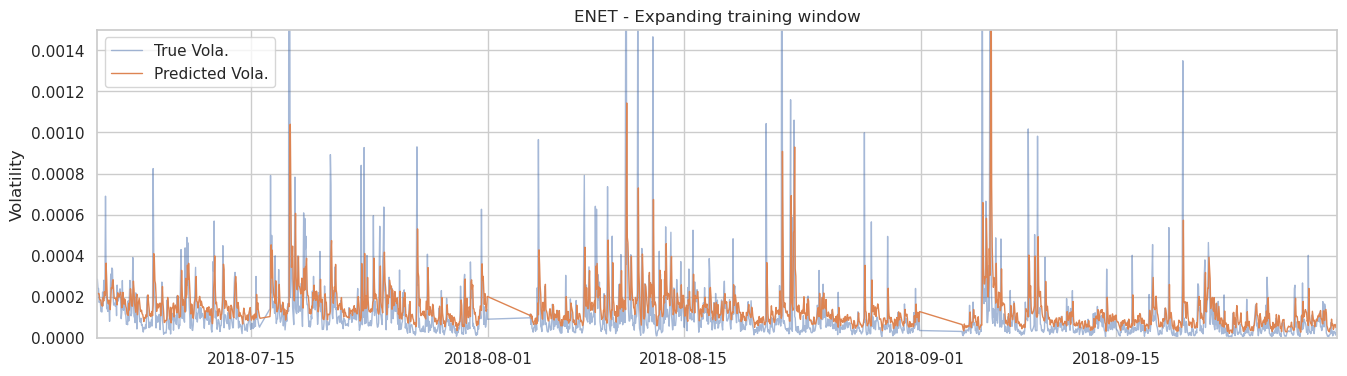

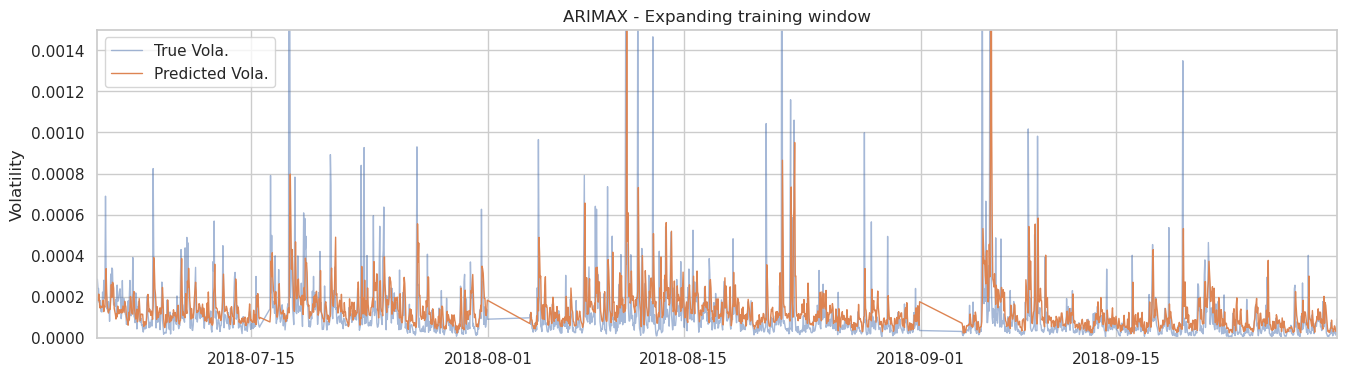

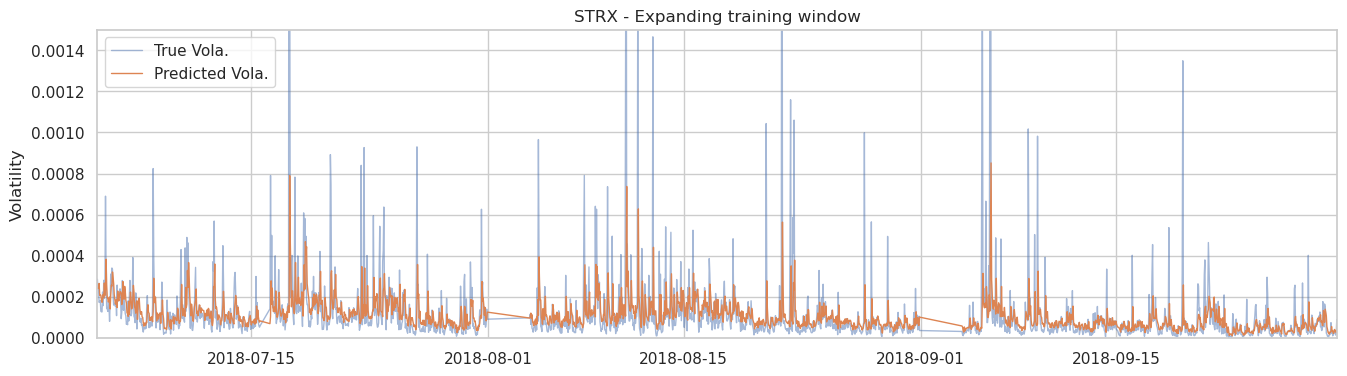

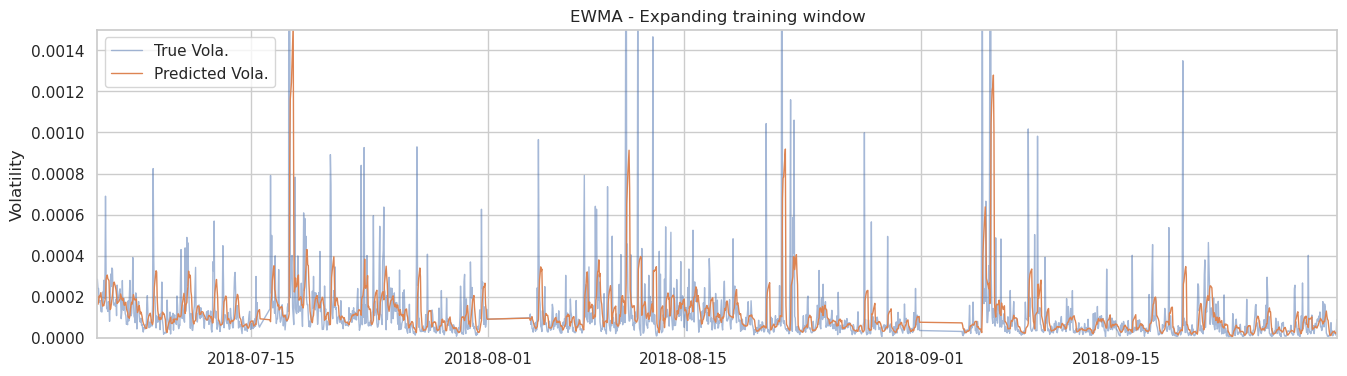

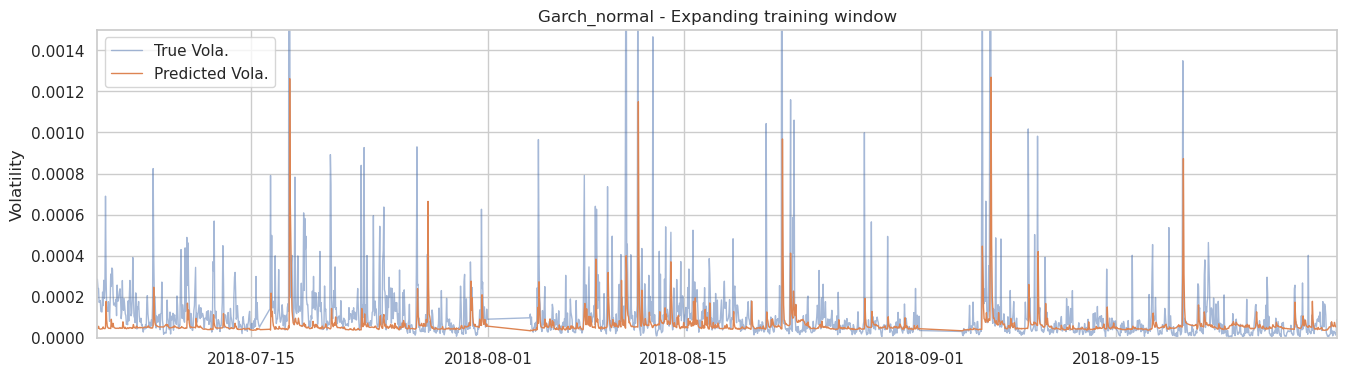

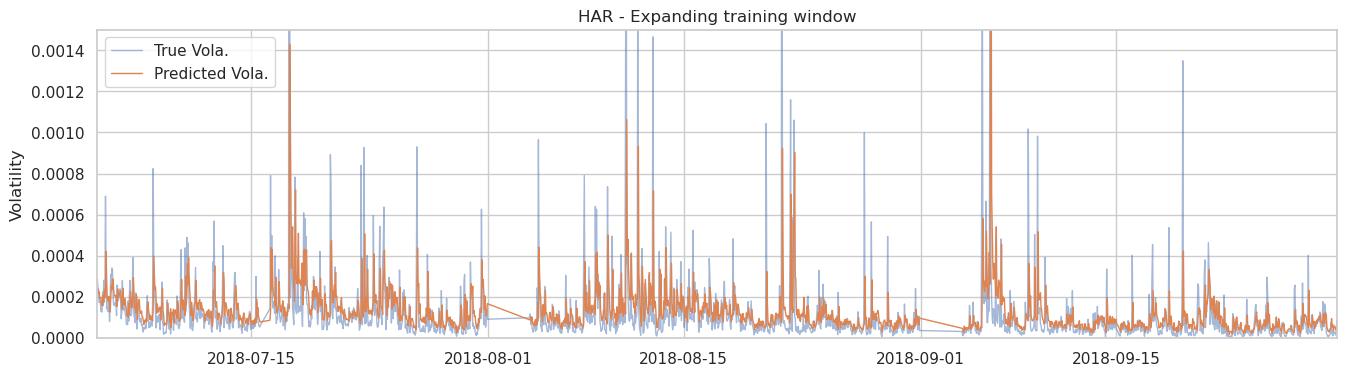

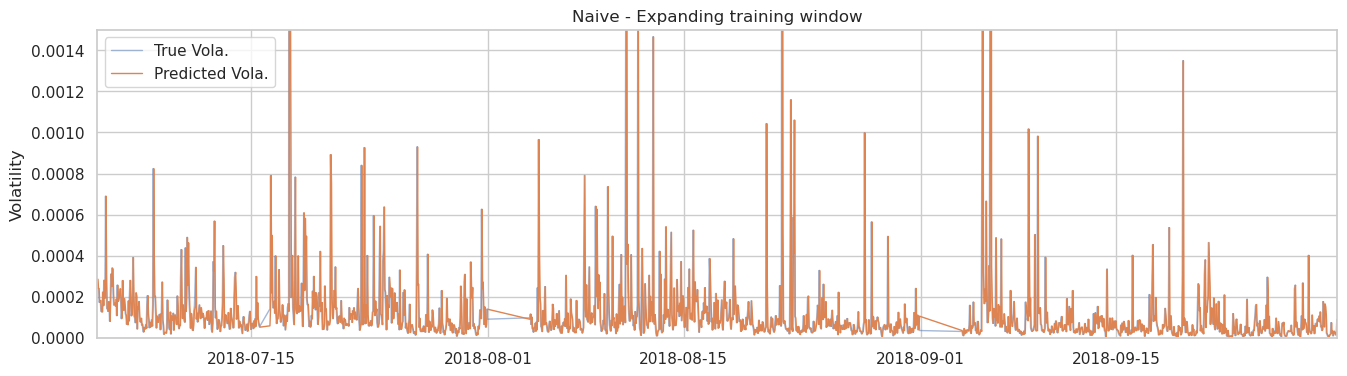

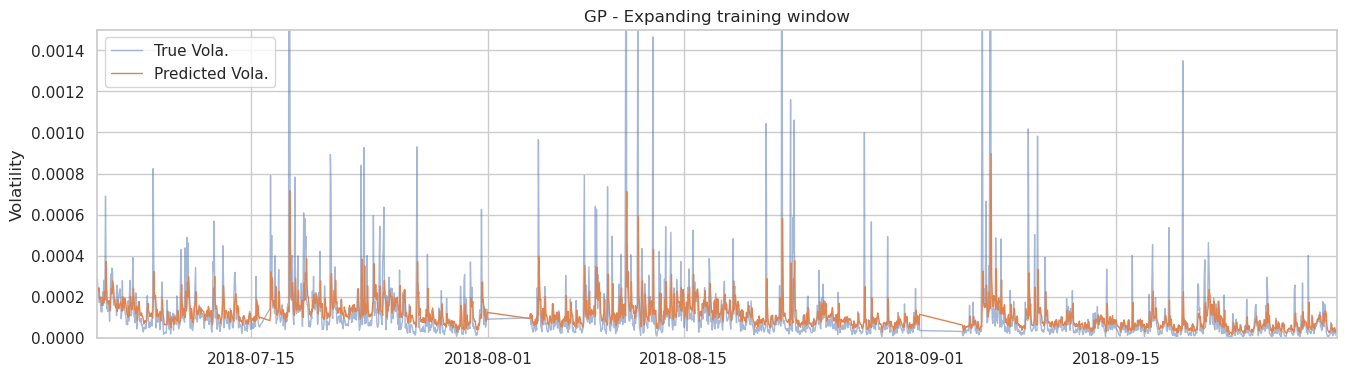

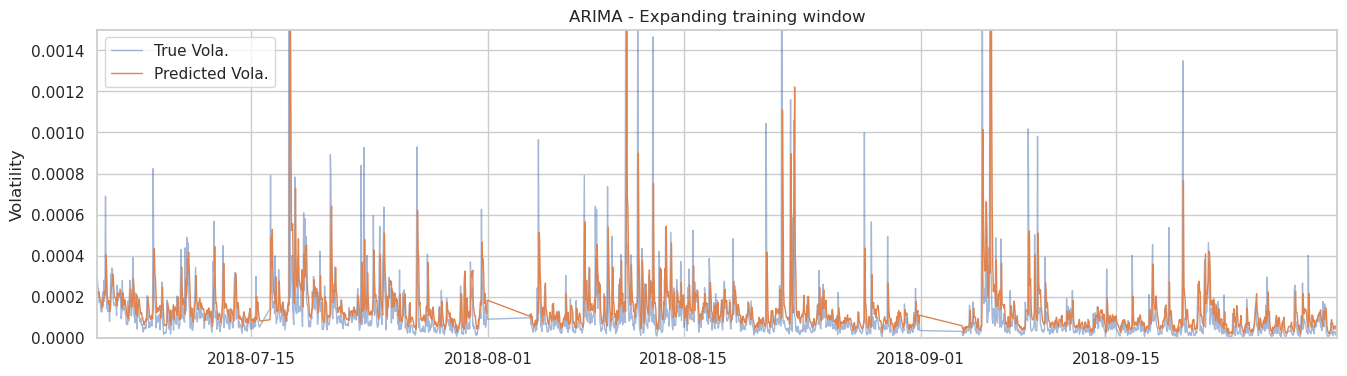

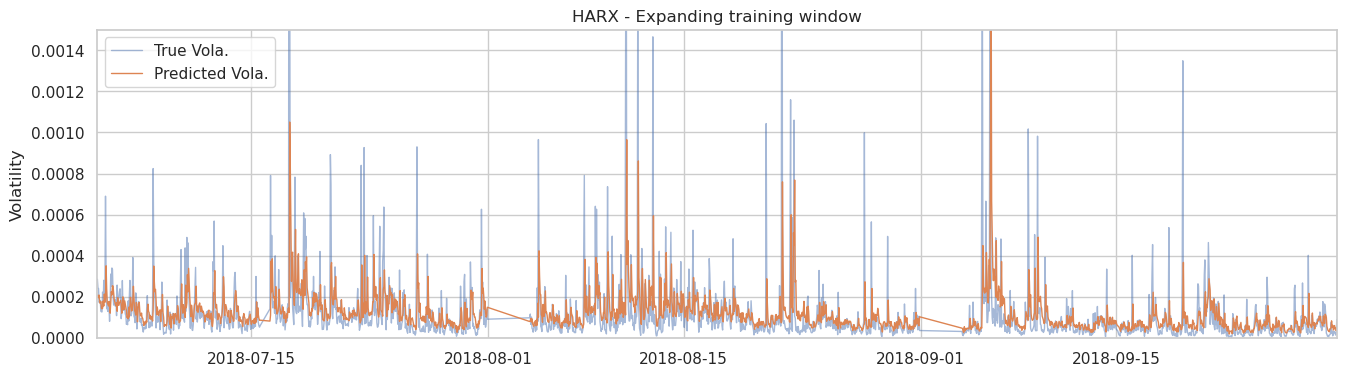

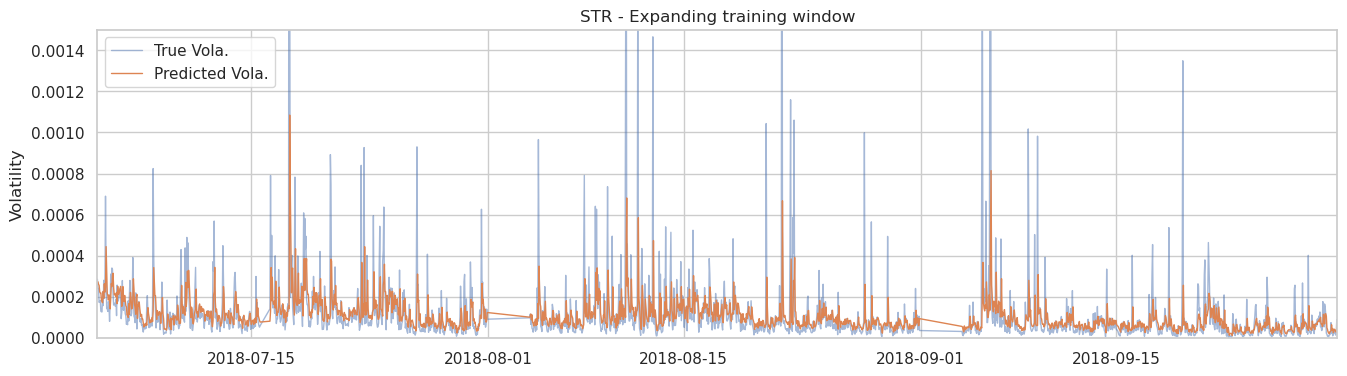

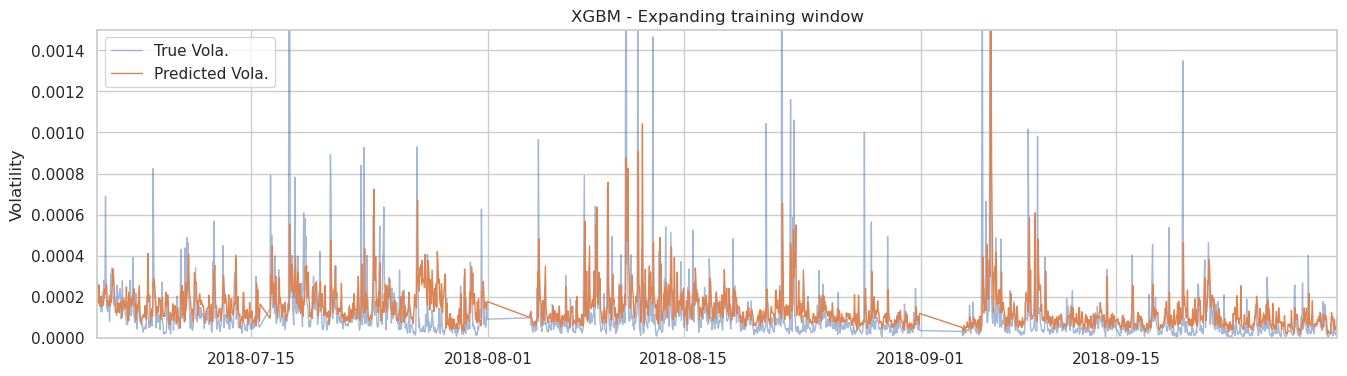

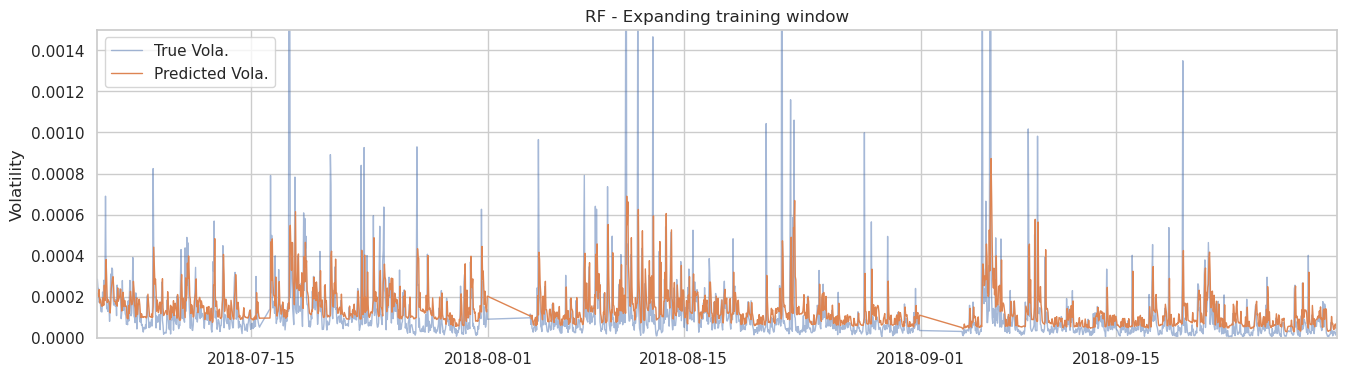

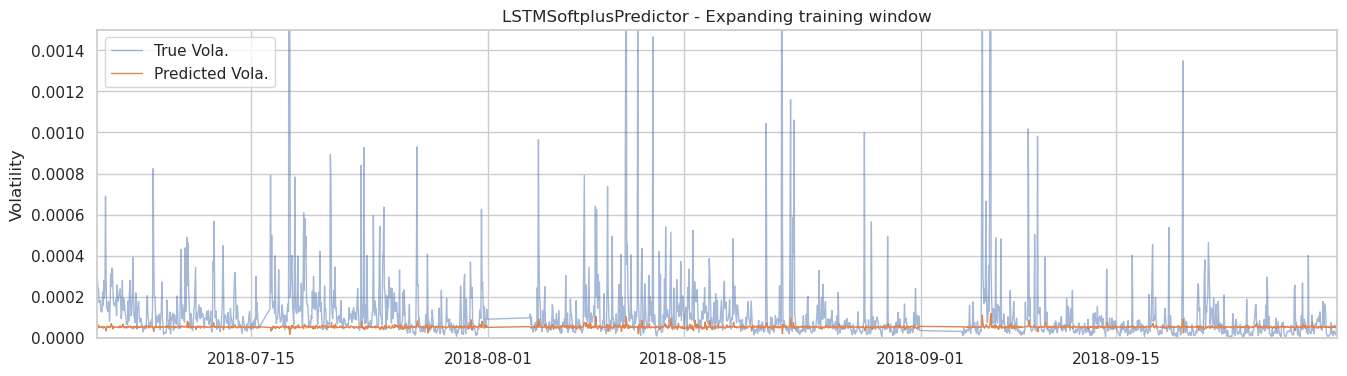

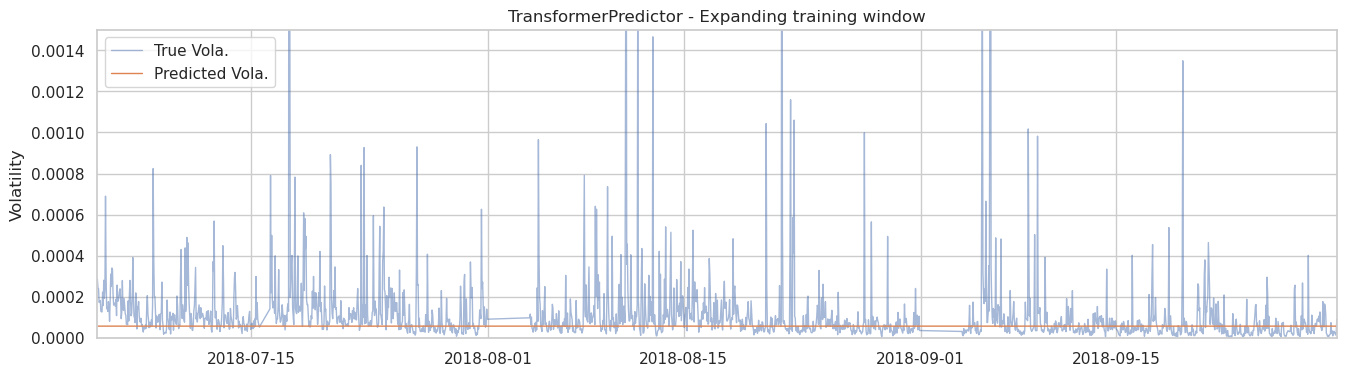

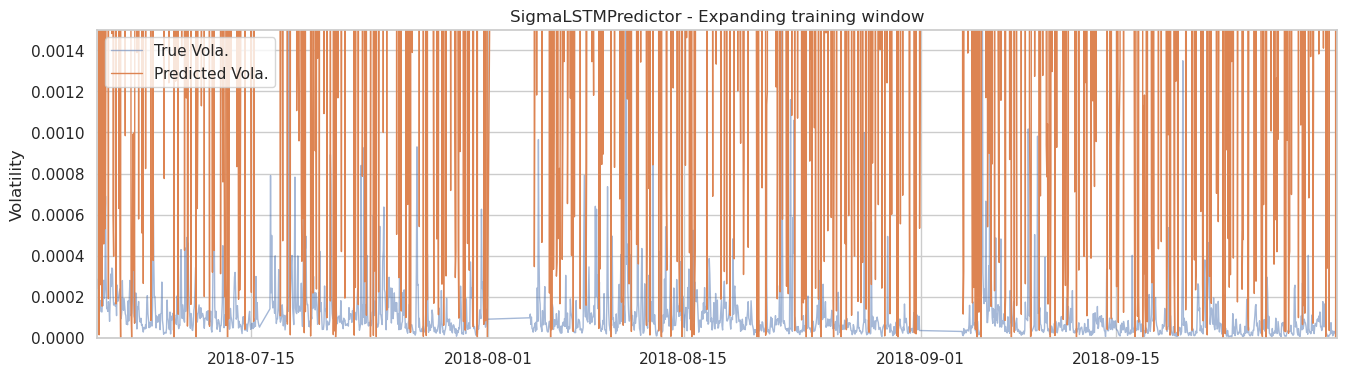

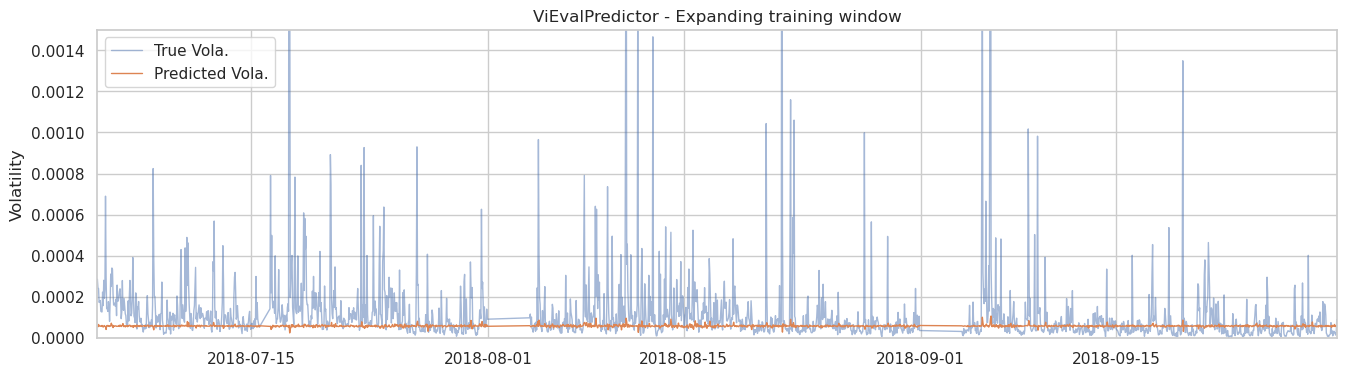

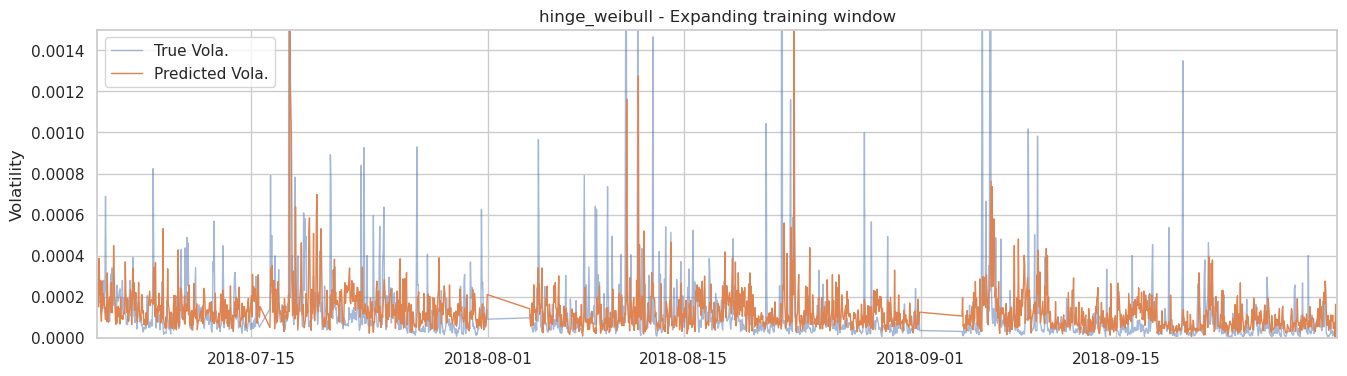

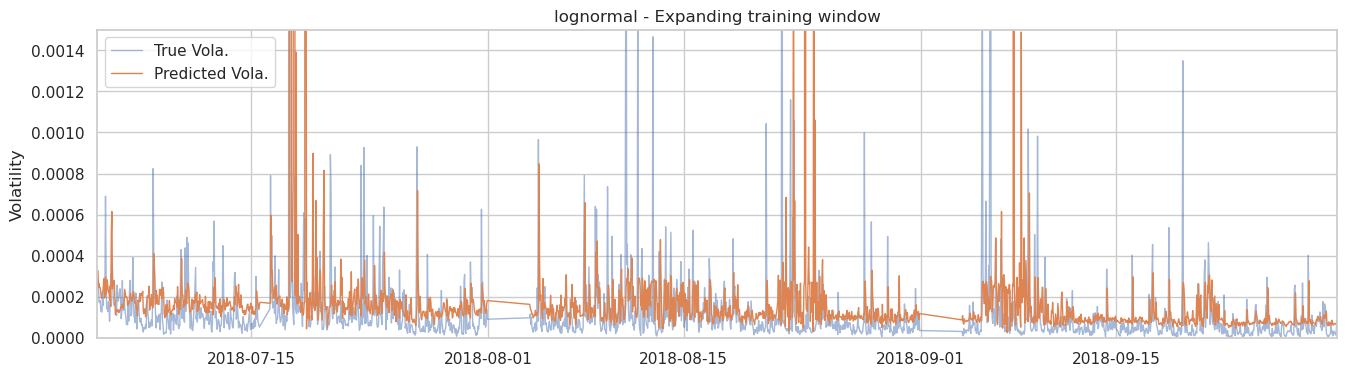

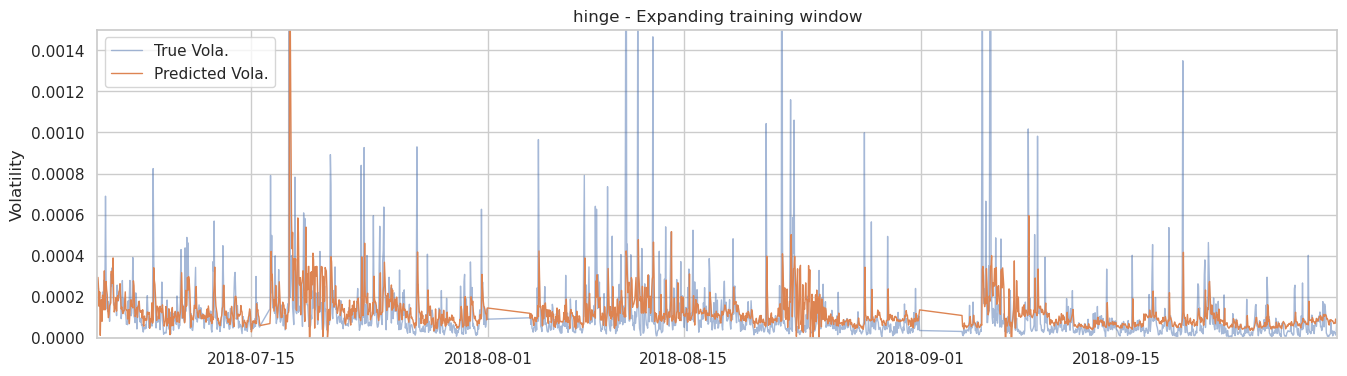

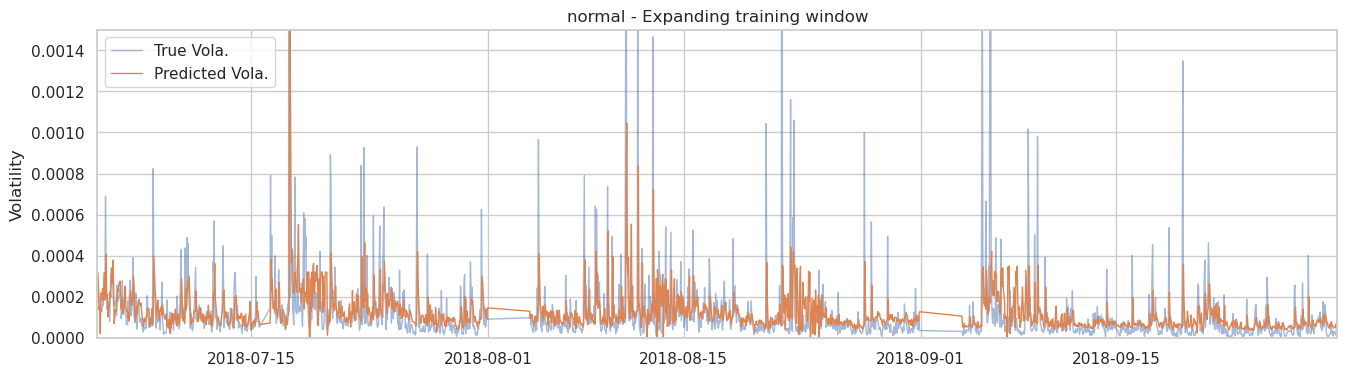

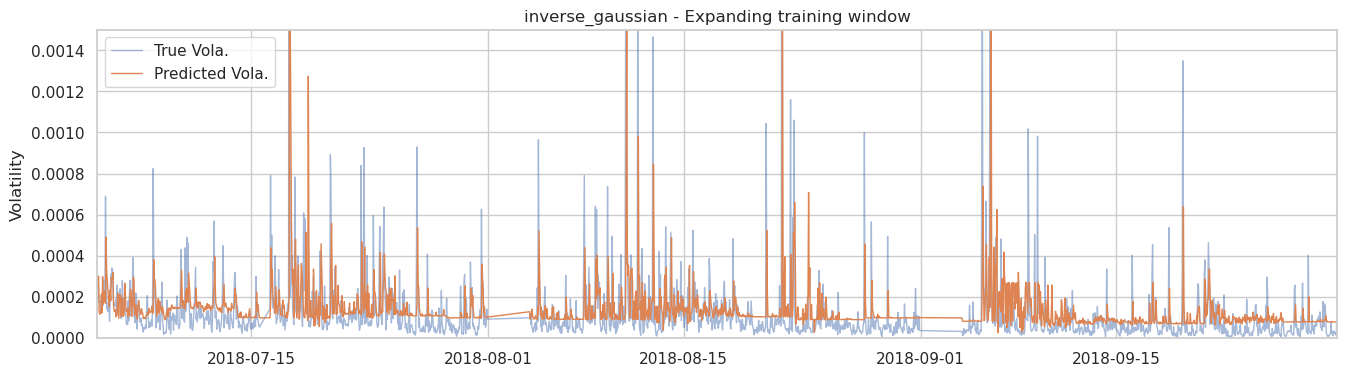

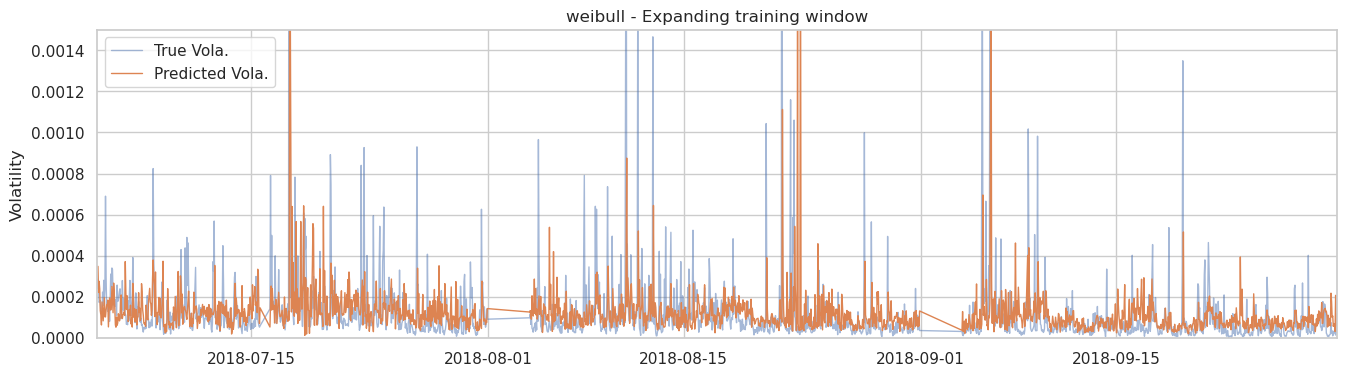

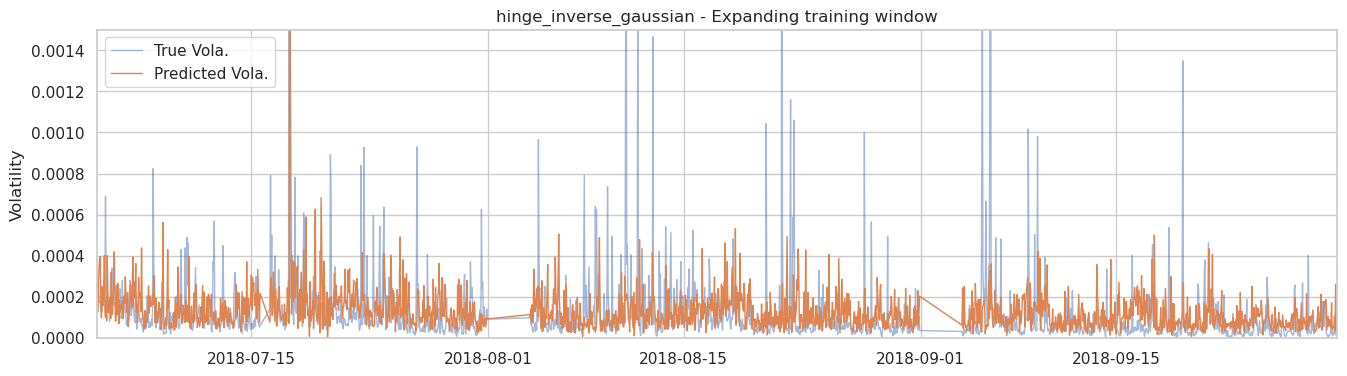

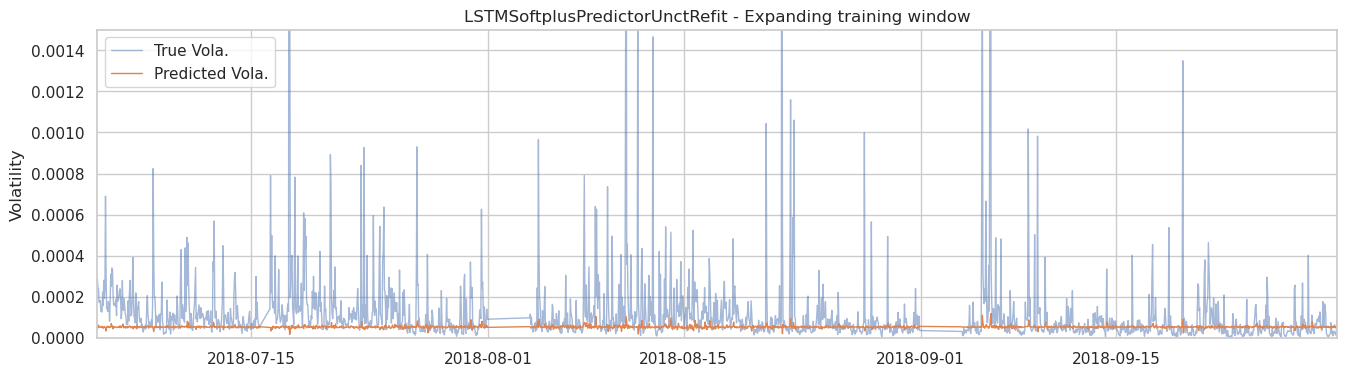

In [38]:
# for all models, plot the predictions vs true volatility

for col in predictions_expanding.columns:
    plt.figure(figsize=(16, 4))

    plt.plot(true_volatility, label='True Vola.', alpha=0.5,  linewidth=1)
    plt.plot(predictions_expanding[col], label='Predicted Vola.', linewidth=1)
    plt.title(col + " - Expanding training window")
    plt.ylabel("Volatility")
    plt.ylim(0, 0.0015)
    plt.xlim(true_volatility.index[0], true_volatility.index[-1])
    # y log scale
    #plt.yscale('log')
    plt.legend()
    plt.show()

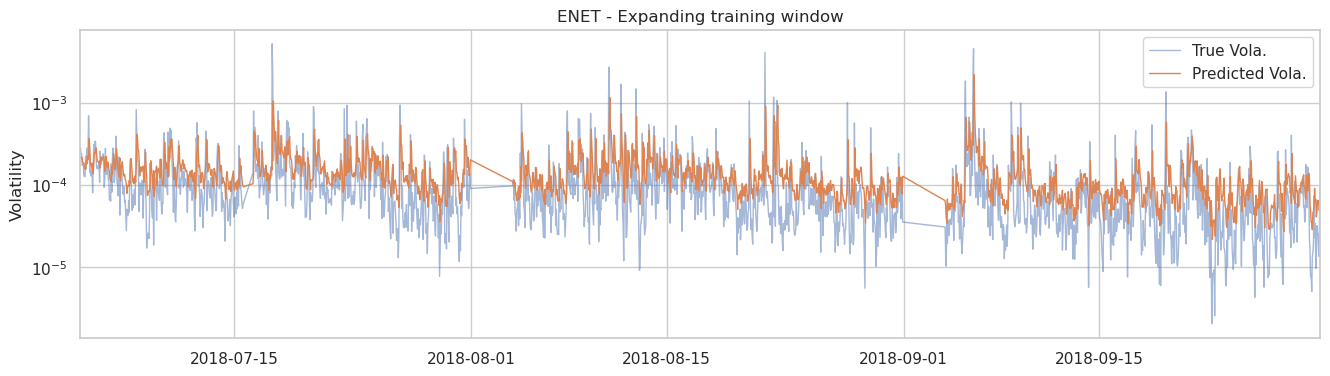

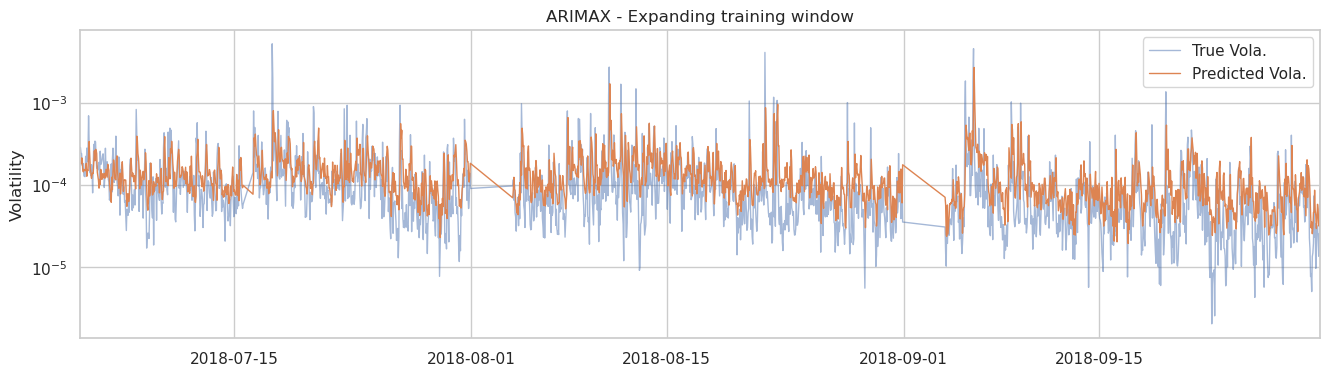

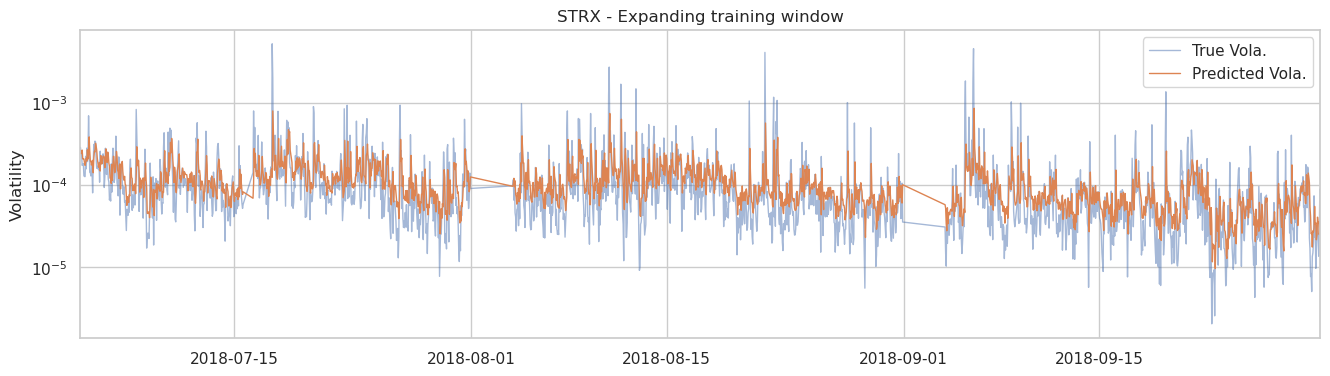

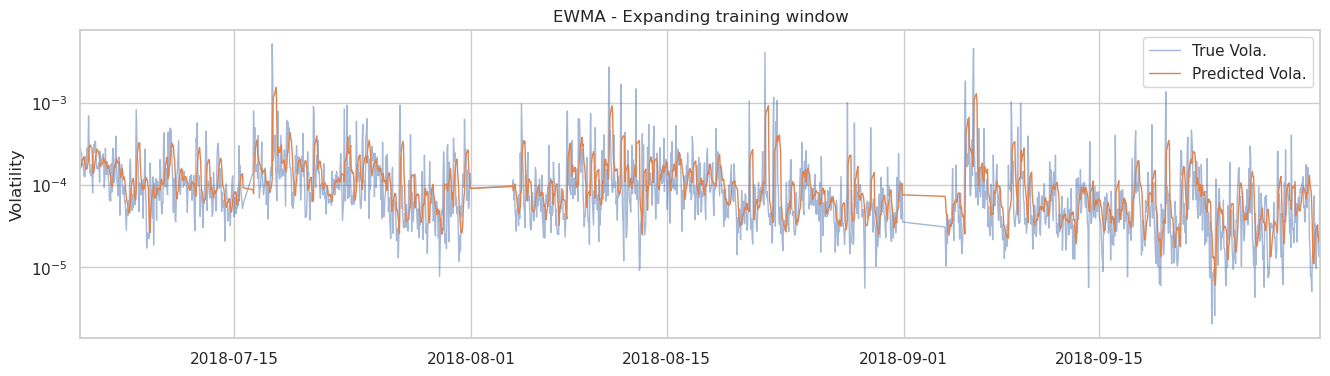

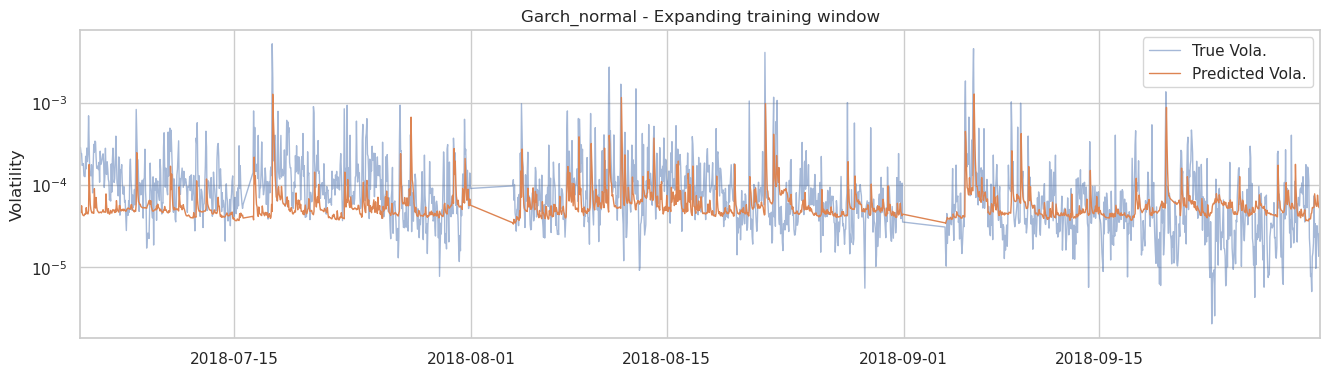

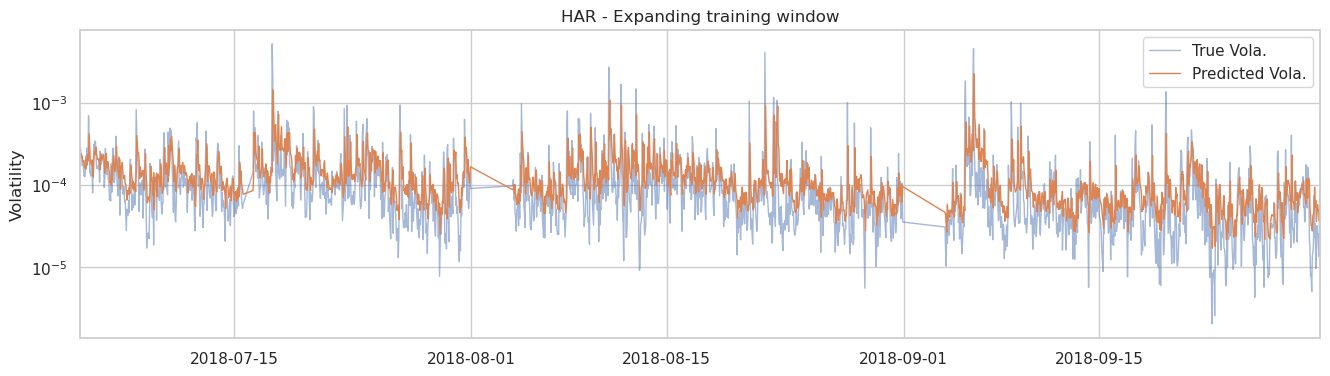

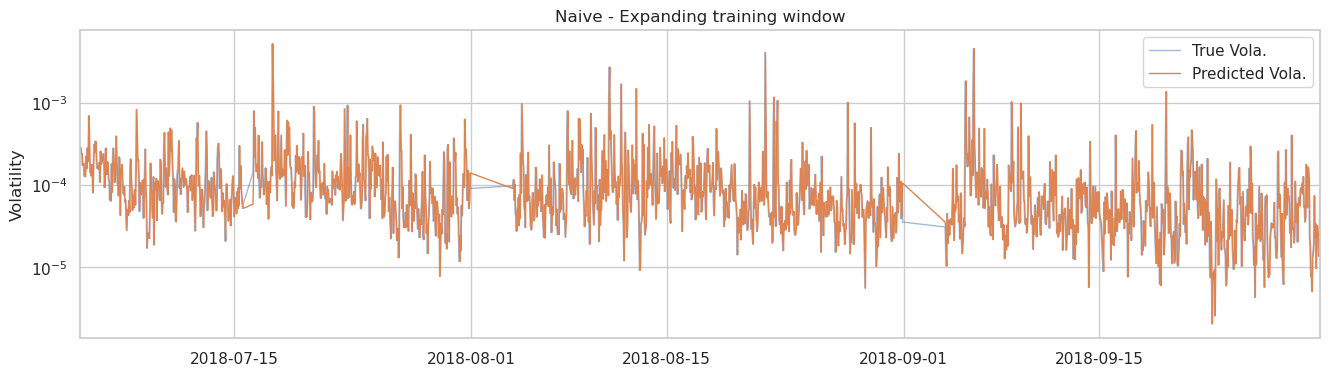

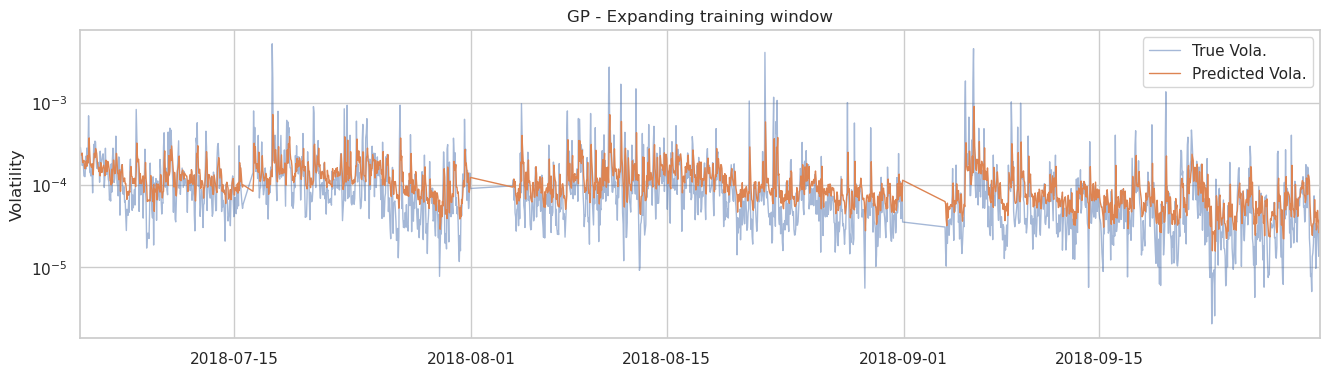

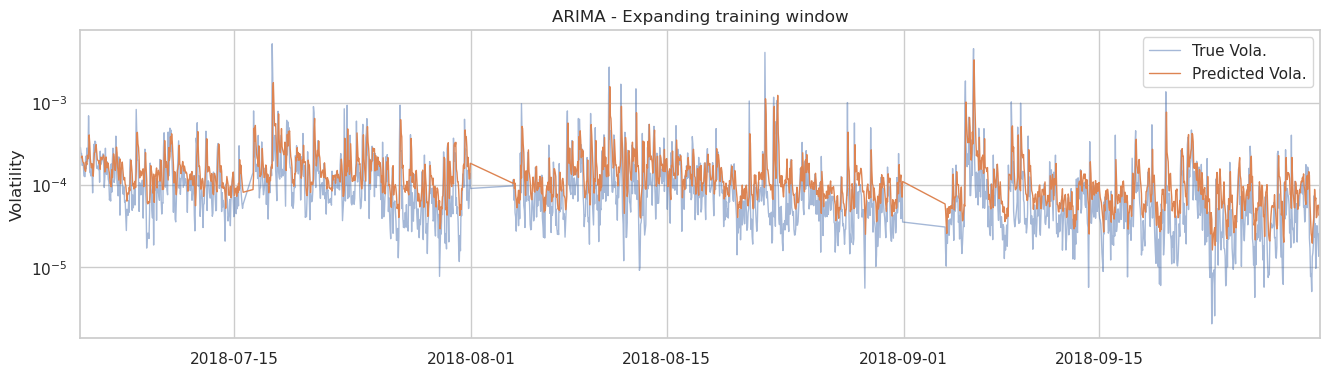

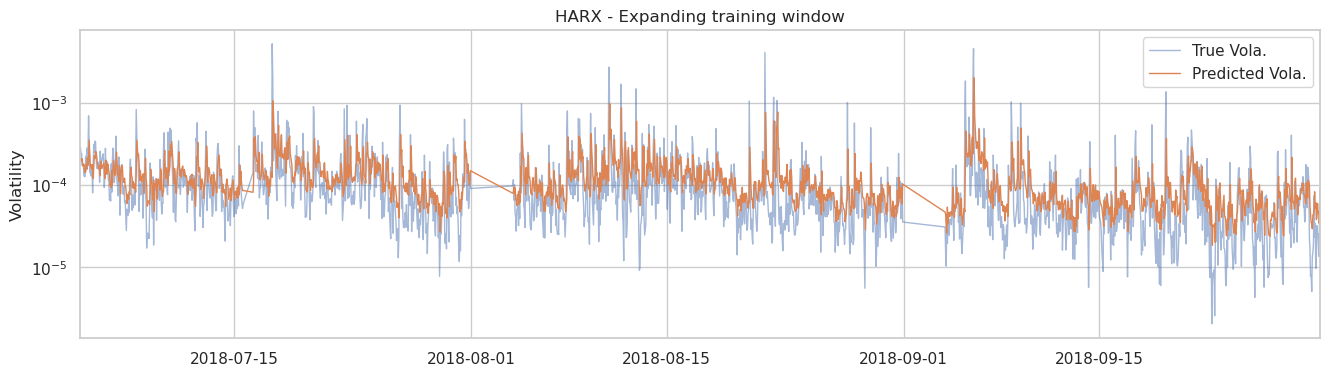

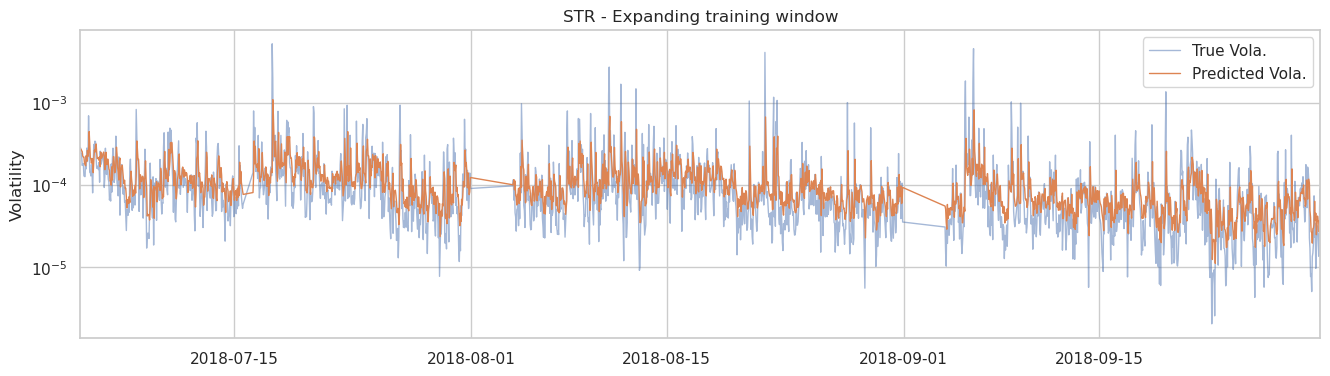

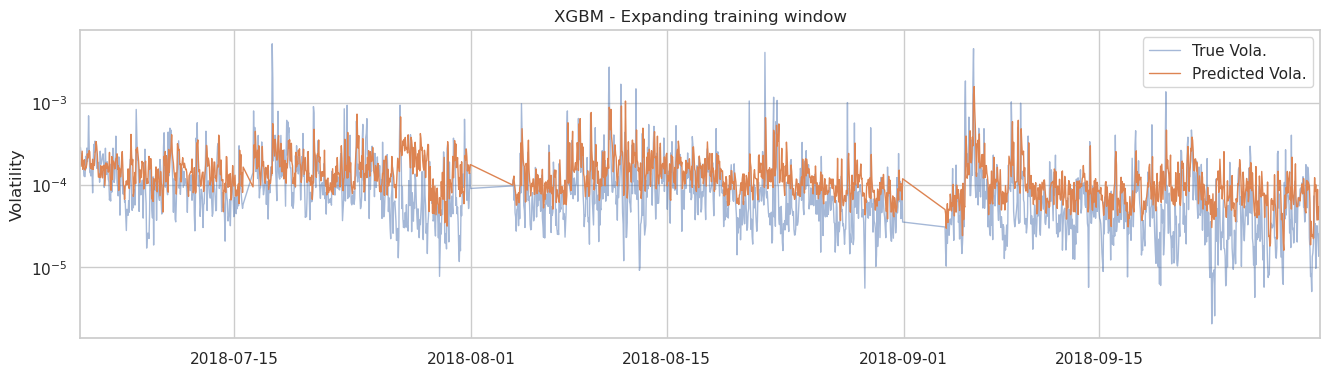

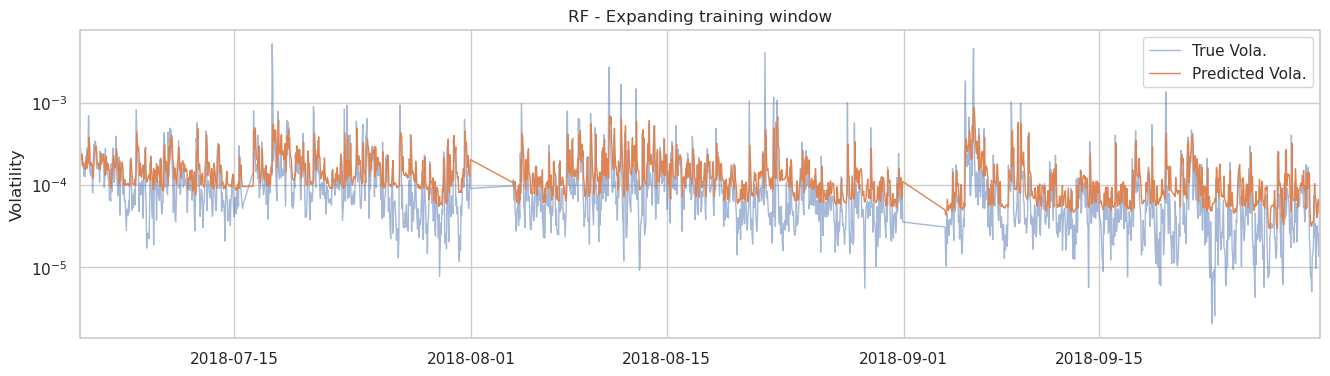

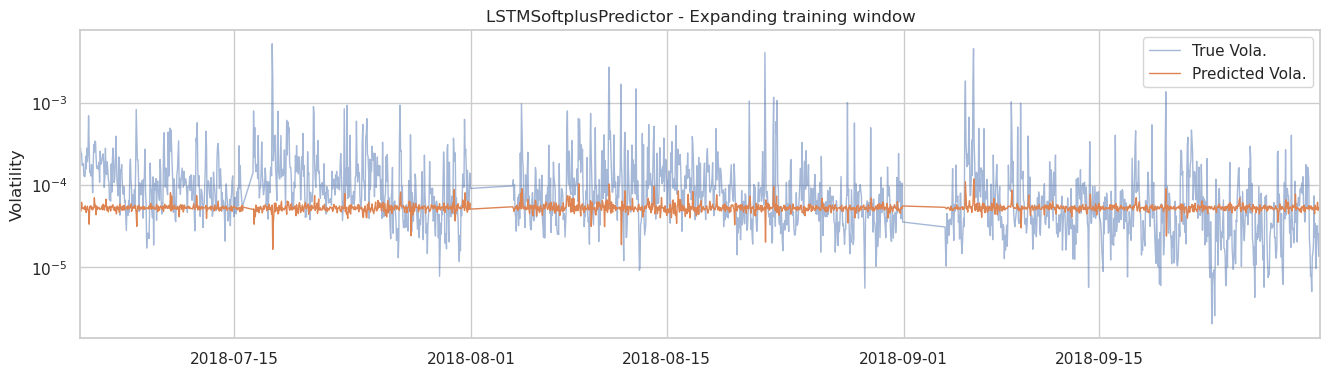

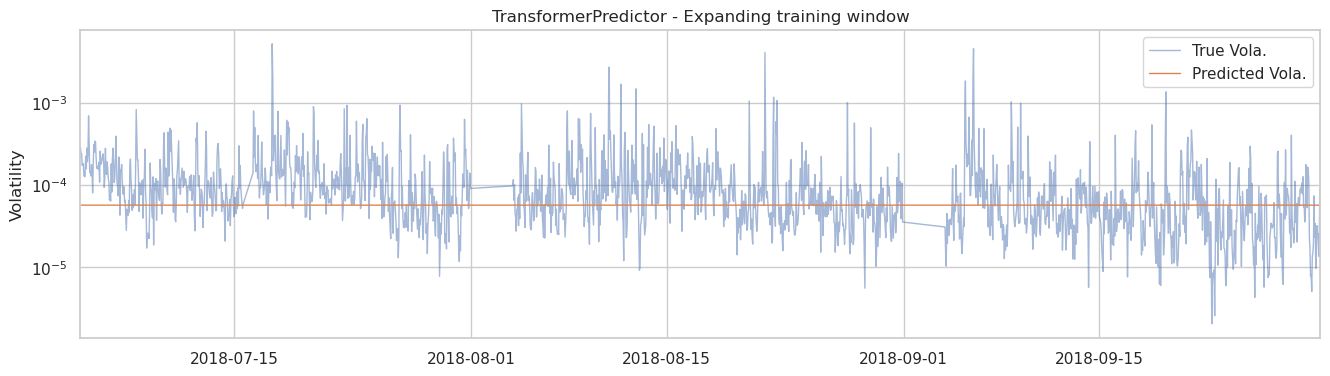

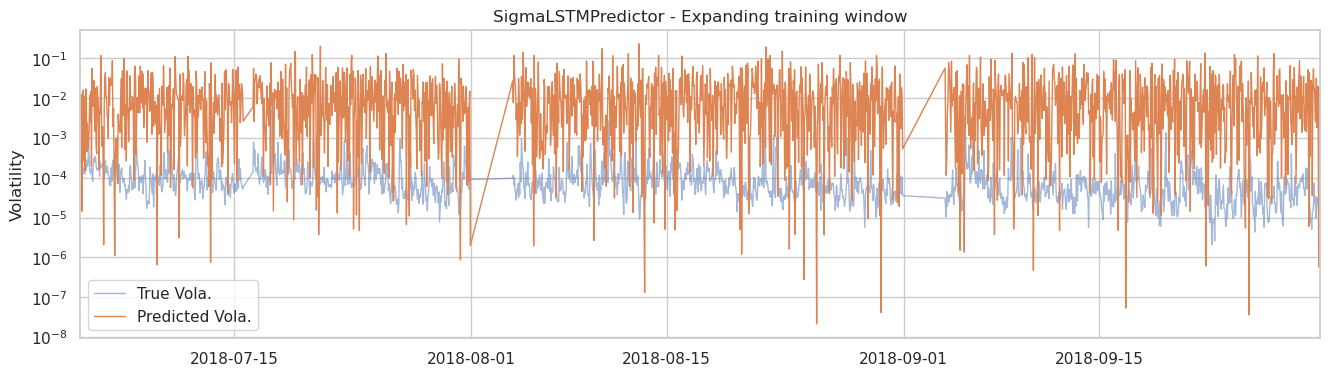

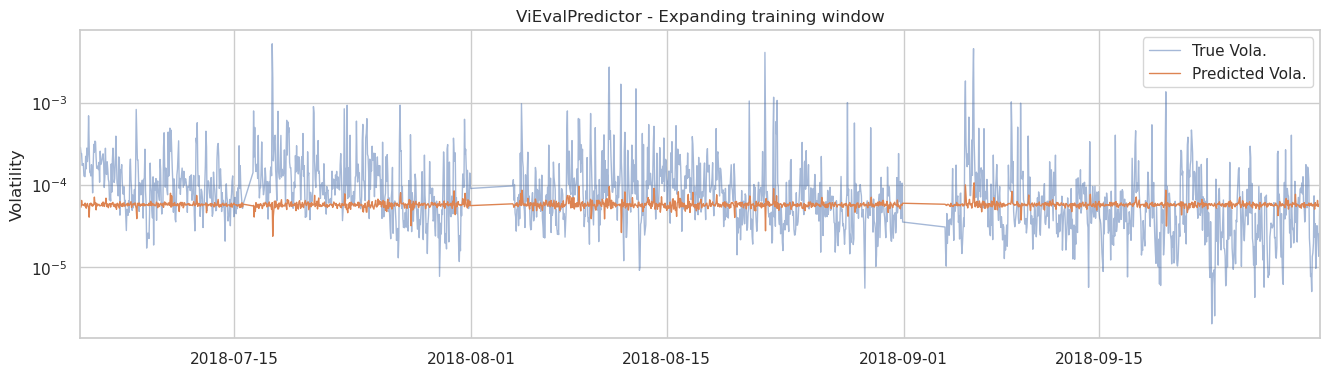

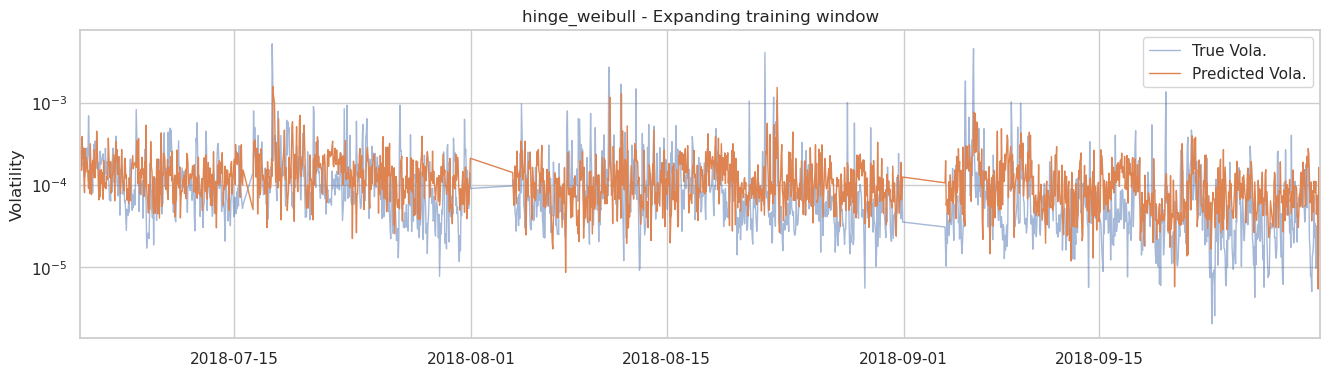

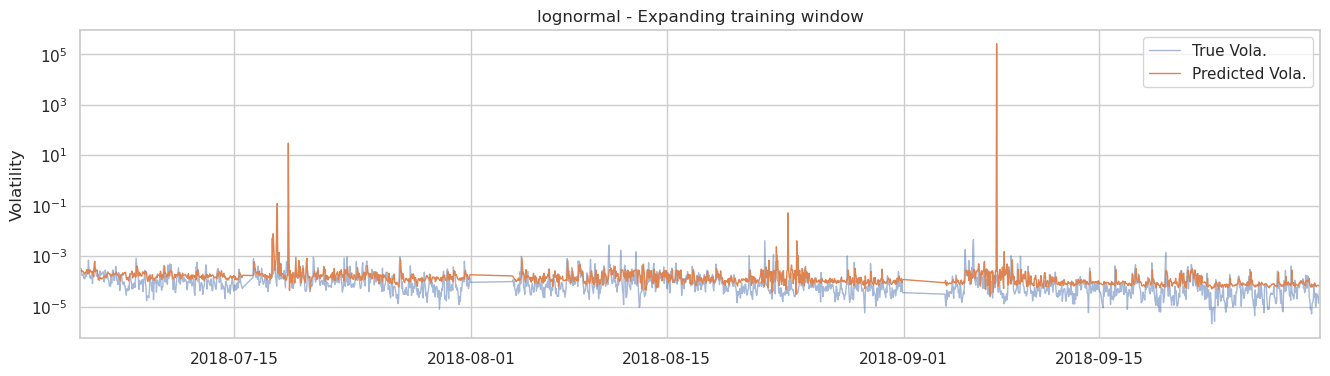

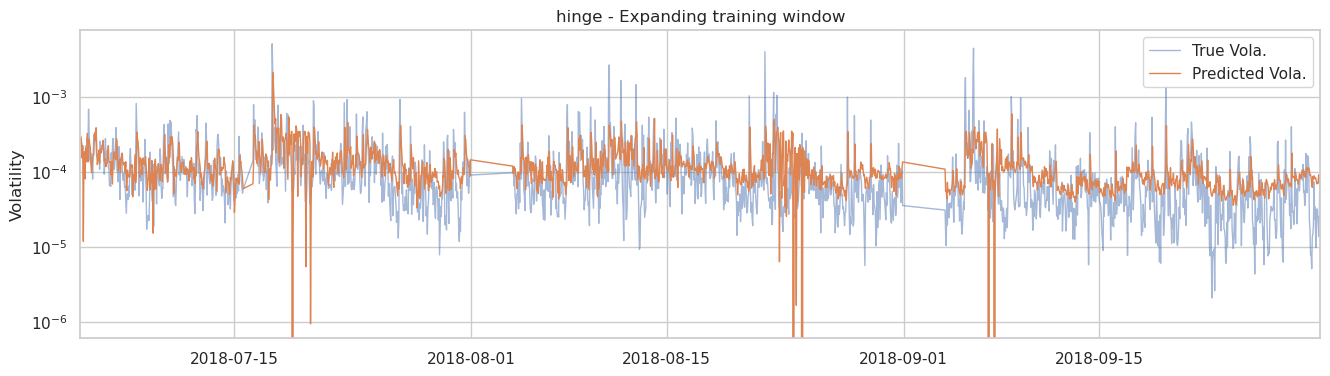

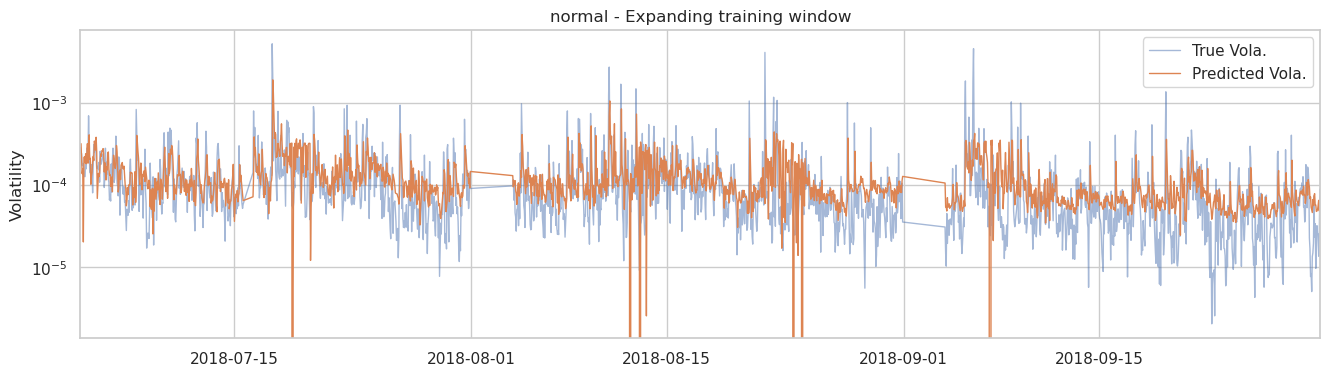

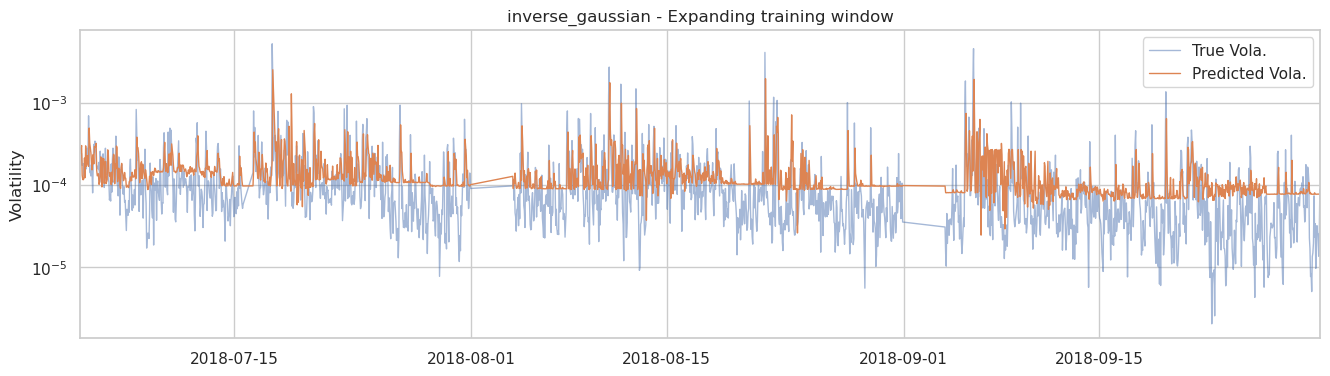

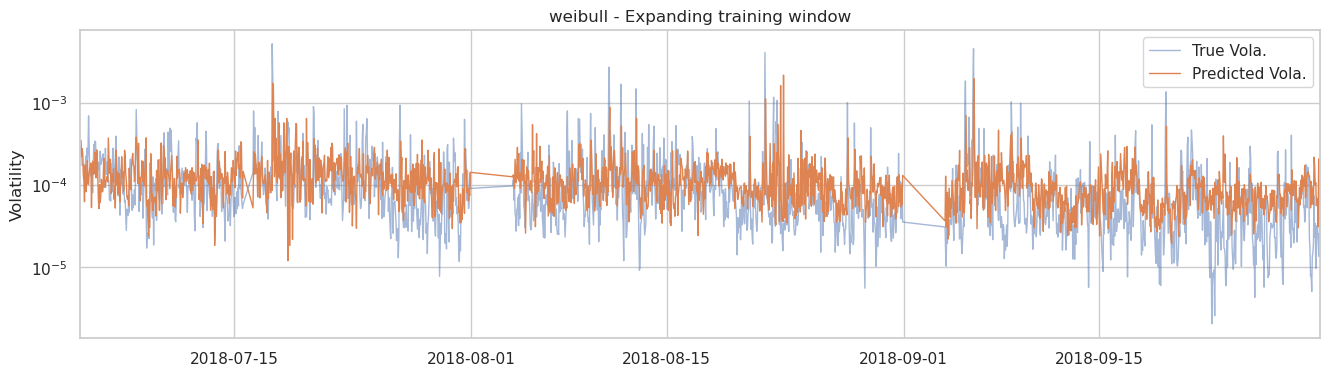

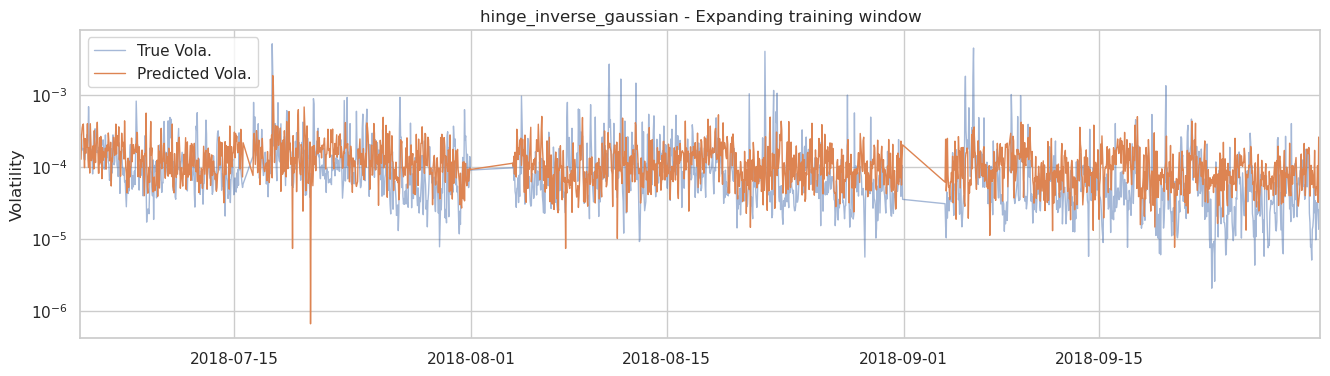

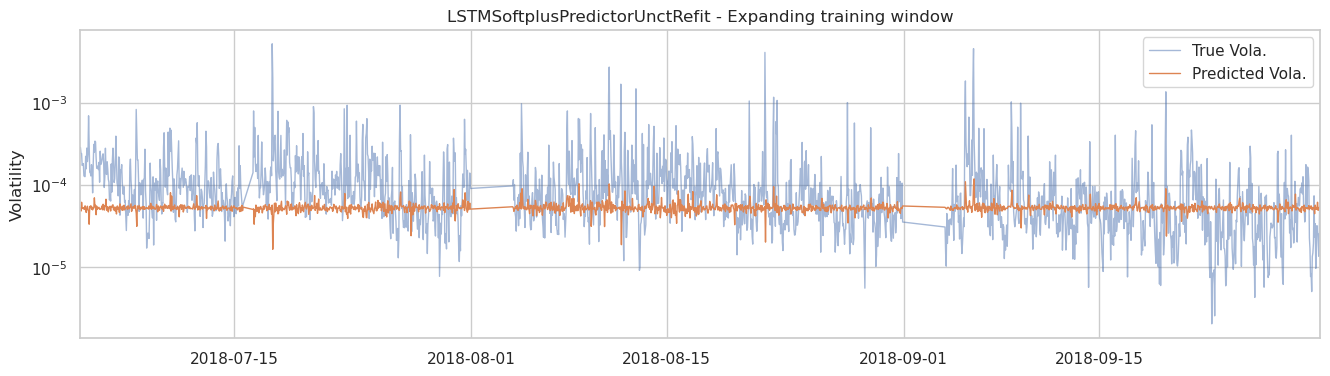

In [39]:
# for all models, plot the predictions vs true volatility

for col in predictions_expanding.columns:
    plt.figure(figsize=(16, 4))

    plt.plot(true_volatility, label='True Vola.', alpha=0.5,  linewidth=1)
    plt.plot(predictions_expanding[col], label='Predicted Vola.', linewidth=1)
    plt.title(col + " - Expanding training window")
    plt.ylabel("Volatility")
    #plt.ylim(0, 0.0015)
    plt.xlim(true_volatility.index[0], true_volatility.index[-1])
    # y log scale
    plt.yscale('log')
    plt.legend()
    plt.show()